#**Project Summary:** Predicting Nutri-Score and Global Applicability
For this project, we utilize the Open Food Facts database as our primary dataset, with the goal of predicting the Nutri-Score — a simplified food labeling system that reflects the nutritional quality of food products.
Nutri-Score was first introduced in France and is now recommended by several European Union countries. It assigns a grade from A (healthiest) to E (least healthy) based on nutrient composition.

**Project Objectives**
1. Build a supervised classification model to predict Nutri-Score using nutritional features from the dataset.
2. Identify suitable countries for Nutri-Score adoption by analyzing external datasets from the World Bank.

**Nutri-Score Prediction**
We developed and evaluated multiple classification models. The best performance was achieved by XGBoost, which reached a test accuracy of 97.84%. This model can be used to assign recommended Nutri-Scores to unlabeled food products.

**Global Applicability**
To assess international applicability, we conducted a complementary analysis using World Bank data. Based on this, we identified the United States as a suitable candidate for Nutri-Score implementation —  The 96.8/100 suitability score for the US exemplifies how data integration reveals non-obvious opportunities - despite being wealthy, the US shows concerning health metrics (high obesity, low food quality scores) that justify intervention, while its 173k analyzed products represent the largest potential market impact globally.

**Impact**
With a high-performing model and evidence-based global insights, this project supports the extension of Nutri-Score to new markets, helping consumers make healthier dietary choices worldwide.




#**Importing All Libraries**

In [2]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Installation commands (run once if packages not installed)
'''!pip install wbdata
!pip install fuzzywuzzy
!pip install pycountry
!pip install xgboost
!pip install pandas-datareader eurostat pandasdmx'''

# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# System and file operations
import os
import io
import json
import zipfile
import requests
from datetime import datetime
import time

# Google Colab specific (if using Colab)
from google.colab import drive

# World Bank data fetching
import wbdata

# Country mapping and string matching
import pycountry
from fuzzywuzzy import fuzz, process
from collections import Counter, defaultdict
from difflib import SequenceMatcher
import re

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, silhouette_score, calinski_harabasz_score
import xgboost as xgb
from xgboost import XGBClassifier

# Statistical analysis
try:
    from scipy import stats
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist, squareform
    print(" Scipy imported successfully")
except ImportError:
    print(" Scipy not available - some statistical features will be limited")

print(" All libraries imported successfully!")
print(" Ready for data analysis")
print("\n" + "="*50)

#**Part I: Open Food Facts Data EDA**


##Step 1.Setup and Initial Data Inspection

**This notebook begins by:**

* Importing essential Python libraries for data processing (pandas, numpy), visualization (matplotlib, seaborn), file handling (os), and warning suppression (warnings).

* Mounting Google Drive to access the Kaggle API key (kaggle.json) for authentication.

* Downloading the OpenFoodFacts dataset from Kaggle and unzipping it to the local environment.

* Defining the file path for the dataset (en.openfoodfacts.org.products.tsv), verifying its existence, and calculating its size.

* Loading a sample of 1,000 rows from the dataset to explore its structure, including its shape, number of columns, and the first 20 column names.

These steps prepare the environment and provide an initial understanding of the dataset’s structure without processing the entire file.

The dataset is sourced from the OpenFoodFacts database: https://www.kaggle.com/openfoodfacts/world-food-facts


In [3]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Mount Google Drive (for kaggle.json file)
drive.mount('/content/drive')

# Set up Kaggle API
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions

# Download Kaggle dataset
print("📥 Downloading the OpenFoodFacts dataset...")
!kaggle datasets download -d openfoodfacts/world-food-facts

# Unzip the dataset
print("\n📂 Unzipping the dataset...")
!unzip /content/world-food-facts.zip

# Set file path
file_path = '/content/en.openfoodfacts.org.products.tsv'

# Check if file exists
if os.path.exists(file_path):
    print("✅ File found!")

    # Check file size
    file_size = os.path.getsize(file_path) / (1024**2)
    print(f"📁 File size: {file_size:.2f} MB")

    # Load sample data (first 1000 rows)
    print("\n🔍 Loading sample data to explore structure...")
    df_sample = pd.read_csv(file_path,
                           sep='\t',
                           nrows=1000,  # Load only the first 1000 rows
                           low_memory=False)

    print(f"Sample data shape: {df_sample.shape}")
    print(f"Number of columns: {len(df_sample.columns)}")

    print("\n First 20 column names:")
    for i, col in enumerate(df_sample.columns[:20]):
        print(f"{i+1:2d}. {col}")

    # Load the full dataset
    print("\n📈 Loading the full dataset... (this may take some time)")
    df = pd.read_csv(file_path,
                     sep='\t',
                     low_memory=False,
                     encoding='utf-8')

    print("✅ Data loaded successfully!")
    print(f"📊 Full dataset shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

else:
    print("❌ File not found. Please check the path.")

Mounted at /content/drive
📥 Downloading the OpenFoodFacts dataset...
Dataset URL: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts
License(s): DbCL-1.0
 73% 79.0M/109M [00:00<00:00, 814MB/s]
100% 109M/109M [00:00<00:00, 693MB/s] 

📂 Unzipping the dataset...
Archive:  /content/world-food-facts.zip
  inflating: en.openfoodfacts.org.products.tsv  
✅ File found!
📁 File size: 963.46 MB

🔍 Loading sample data to explore structure...
Sample data shape: (1000, 163)
Number of columns: 163

 First 20 column names:
 1. code
 2. url
 3. creator
 4. created_t
 5. created_datetime
 6. last_modified_t
 7. last_modified_datetime
 8. product_name
 9. generic_name
10. quantity
11. packaging
12. packaging_tags
13. brands
14. brands_tags
15. categories
16. categories_tags
17. categories_en
18. origins
19. origins_tags
20. manufacturing_places

📈 Loading the full dataset... (this may take some time)
✅ Data loaded successfully!
📊 Full dataset shape: (356027, 163)
💾 Memory usage: 2023.62 MB


## Step 2.Data Loading and Preprocessing

**Initial Dataset Overview**

**Objective:** Begin preprocessing by examining the dataset structure and key features.

**Actions performed:**

* Display dataset dimensions (rows × columns) and total data points.

* Review the distribution of data types to understand column formats.

* Identify and preview key columns (e.g., product identifiers, nutritional values) that are essential for further analysis.

In [4]:
# Step 2: Data Loading and Preprocessing
print("="*60)
print("PART I: DATA LOADING AND PREPROCESSING")
print("="*60)

print("\n1.1 Dataset Overview")
print("-"*30)

# Basic information
print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Total data points: {df.shape[0] * df.shape[1]:,}")

# Check data types
print(f"\nData types:")
print(df.dtypes.value_counts())

# Preview first 5 rows (key columns only)
key_columns = ['code', 'product_name', 'brands', 'categories', 'countries',
               'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']

# Filter only the columns that exist
existing_key_cols = [col for col in key_columns if col in df.columns]
print(f"\nPreview of key columns ({len(existing_key_cols)} total):")
print(existing_key_cols)

if existing_key_cols:
    print("\nFirst 5 rows:")
    print(df[existing_key_cols].head())

PART I: DATA LOADING AND PREPROCESSING

1.1 Dataset Overview
------------------------------
Dataset dimensions: 356027 rows × 163 columns
Total data points: 58,032,401

Data types:
float64    107
object      56
Name: count, dtype: int64

Preview of key columns (9 total):
['code', 'product_name', 'brands', 'categories', 'countries', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']

First 5 rows:
            code                    product_name           brands categories  \
0  0000000003087              Farine de blé noir  Ferme t'y R'nao        NaN   
1  0000000004530  Banana Chips Sweetened (Whole)              NaN        NaN   
2  0000000004559                         Peanuts   Torn & Glasser        NaN   
3  0000000016087          Organic Salted Nut Mix        Grizzlies        NaN   
4  0000000016094                 Organic Polenta   Bob's Red Mill        NaN   

  countries  energy_100g  fat_100g  carbohydrates_100g  proteins_100g  
0     en:FR          NaN       N

**2.1 Missing Values Analysis**
Objective: Identify the extent of missing data across columns to inform preprocessing strategies.

Actions performed:

* Calculate the missing value count and percentage for every column.

* Sort columns by the percentage of missing data to prioritize which features require handling.

* Visualize the Top 15 columns with the highest proportion of missing values for quick assessment.


1.2 Missing Values Analysis
------------------------------
Top 20 columns with the most missing values:
                                                                      Column  \
ingredients_from_palm_oil                          ingredients_from_palm_oil   
ingredients_that_may_be_from_palm_oil  ingredients_that_may_be_from_palm_oil   
no_nutriments                                                  no_nutriments   
chlorophyl_100g                                              chlorophyl_100g   
water-hardness_100g                                      water-hardness_100g   
glycemic-index_100g                                      glycemic-index_100g   
-butyric-acid_100g                                        -butyric-acid_100g   
-melissic-acid_100g                                      -melissic-acid_100g   
-nervonic-acid_100g                                      -nervonic-acid_100g   
-erucic-acid_100g                                          -erucic-acid_100g   
-mead-acid_100g

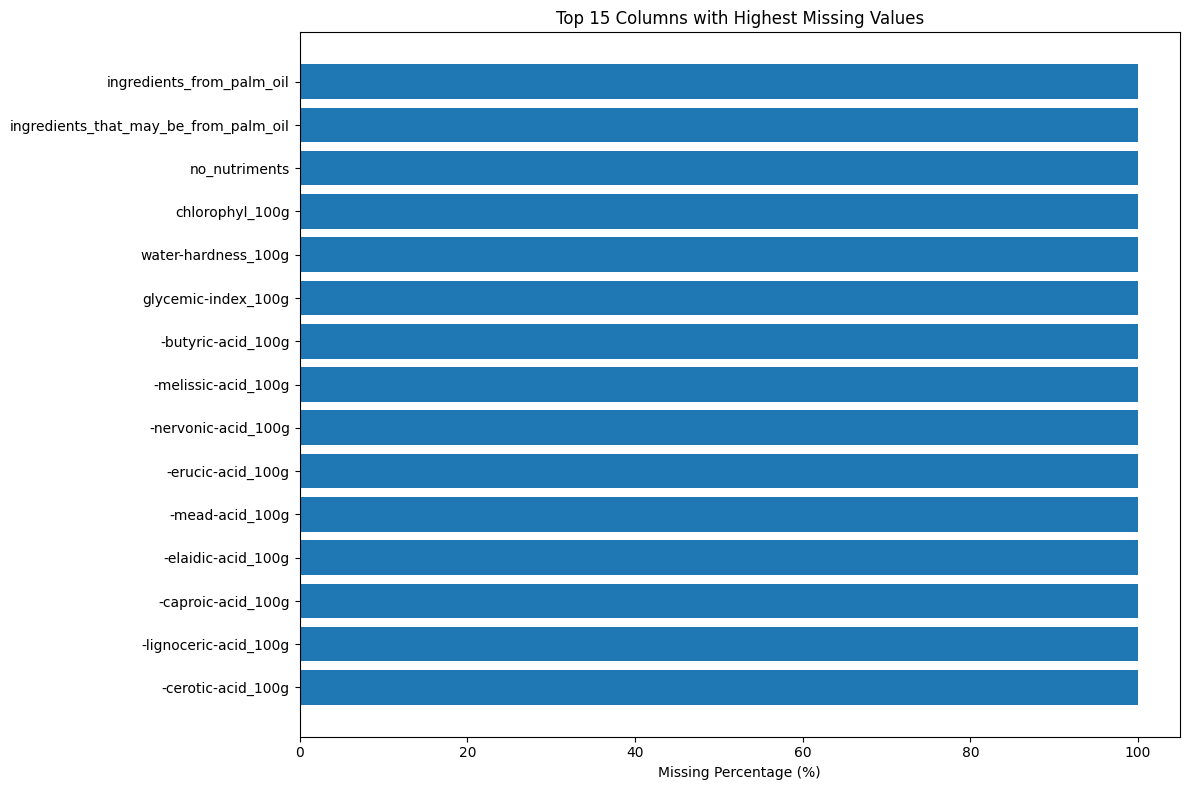

In [ ]:
# 2.1 Missing Values Analysis
print("\n1.2 Missing Values Analysis")
print("-"*30)

# Calculate missing value ratio
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
}).sort_values('Missing_Percentage', ascending=False)

# Top 20 columns with the most missing values
print("Top 20 columns with the most missing values:")
print(missing_df.head(20)[['Column', 'Missing_Percentage']].round(2))

# Visualize missing values
top_missing = missing_df.head(15)
plt.figure(figsize=(12, 8))
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Top 15 Columns with Highest Missing Values')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**2.2 Identifying Nutrition-Related Columns**

Objective: Detect columns that contain nutritional information (e.g., energy, fat, protein) for focused analysis.

Approach:

* Search column names for nutrition-related keywords (energy, fat, carbohydrates, protein, sugar, fiber, sodium, salt, calcium, vitamin).

* Compile a list of all matching columns to be used in later nutritional profiling.

In [ ]:
# 2.2 Finding Nutrition-Related Columns
print("\n1.3 Nutrition-Related Columns")
print("-"*30)

# Find columns related to nutrition using keywords
nutrition_keywords = ['energy', 'fat', 'carbohydrat', 'protein', 'sugar',
                     'fiber', 'sodium', 'salt', 'calcium', 'vitamin']

nutrition_cols = []
for col in df.columns:
    if any(keyword in col.lower() for keyword in nutrition_keywords):
        nutrition_cols.append(col)

print(f"Number of nutrition-related columns: {len(nutrition_cols)}")
print("Nutrition-related columns:")
for i, col in enumerate(nutrition_cols[:]):  #
    print(f"{i+1:2d}. {col}")




1.3 Nutrition-Related Columns
------------------------------
Number of nutrition-related columns: 30
Nutrition-related columns:
 1. energy_100g
 2. energy-from-fat_100g
 3. fat_100g
 4. saturated-fat_100g
 5. monounsaturated-fat_100g
 6. polyunsaturated-fat_100g
 7. omega-3-fat_100g
 8. omega-6-fat_100g
 9. omega-9-fat_100g
10. trans-fat_100g
11. carbohydrates_100g
12. sugars_100g
13. fiber_100g
14. proteins_100g
15. serum-proteins_100g
16. salt_100g
17. sodium_100g
18. vitamin-a_100g
19. vitamin-d_100g
20. vitamin-e_100g
21. vitamin-k_100g
22. vitamin-c_100g
23. vitamin-b1_100g
24. vitamin-b2_100g
25. vitamin-pp_100g
26. vitamin-b6_100g
27. vitamin-b9_100g
28. vitamin-b12_100g
29. calcium_100g
30. collagen-meat-protein-ratio_100g


**Target Variable Analysis: nutrition_grade_fr**

Objective: Explore the Nutri-Score (target variable) distribution, which will be crucial for prediction modeling.

Actions performed:

* Confirm the presence of the nutrition_grade_fr column in the dataset.

* Display the frequency and percentage of each Nutri-Score grade.

* Visualize the distribution using both a bar chart (counts) and pie chart (percentages) to understand class balance.

OPENFOODFACTS DATASET - NUTRI-SCORE EDA

📊 1. TARGET VARIABLE ANALYSIS
--------------------------------------------------
✅ Target variable 'nutrition_grade_fr' found!

Target variable distribution:
nutrition_grade_fr
NaN    101171
d       72436
c       52870
e       50236
a       40304
b       39010
Name: count, dtype: int64

Target variable percentages:
nutrition_grade_fr
NaN    28.42
d      20.35
c      14.85
e      14.11
a      11.32
b      10.96
Name: proportion, dtype: float64


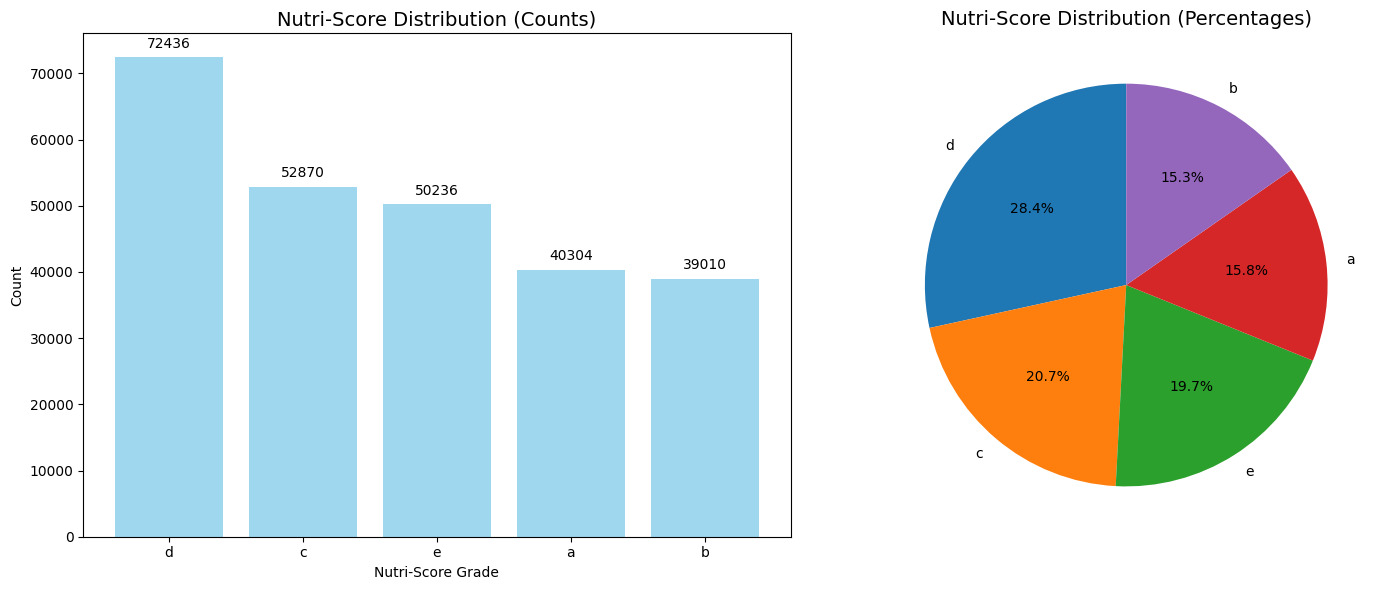

In [ ]:
# OpenFoodFacts Dataset EDA for Nutri-Score Prediction
# Comprehensive Exploratory Data Analysis
print("="*80)
print("OPENFOODFACTS DATASET - NUTRI-SCORE EDA")
print("="*80)

# 1. target variable analysis (nutrition_grade_fr)
print("\n📊 1. TARGET VARIABLE ANALYSIS")
print("-"*50)

# nutrition_grade_fr columns
if 'nutrition_grade_fr' in df.columns:
    print("✅ Target variable 'nutrition_grade_fr' found!")

    # variable distribution
    print(f"\nTarget variable distribution:")
    target_counts = df['nutrition_grade_fr'].value_counts(dropna=False)
    print(target_counts)

    # variable portion
    target_props = df['nutrition_grade_fr'].value_counts(normalize=True, dropna=False) * 100
    print(f"\nTarget variable percentages:")
    print(target_props.round(2))

    # visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # count plots
    target_counts_clean = df['nutrition_grade_fr'].value_counts()
    ax1.bar(target_counts_clean.index, target_counts_clean.values, color='skyblue', alpha=0.8)
    ax1.set_title('Nutri-Score Distribution (Counts)', fontsize=14)
    ax1.set_xlabel('Nutri-Score Grade')
    ax1.set_ylabel('Count')

    # values
    for i, v in enumerate(target_counts_clean.values):
        ax1.text(i, v + 1000, str(v), ha='center', va='bottom')

    # pie chart
    ax2.pie(target_counts_clean.values, labels=target_counts_clean.index,
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Nutri-Score Distribution (Percentages)', fontsize=14)

    plt.tight_layout()
    plt.show()

else:
    print("❌ Target variable 'nutrition_grade_fr' not found!")
    # nutrition related columns
    nutri_cols = [col for col in df.columns if 'nutri' in col.lower()]
    print(f"Found {len(nutri_cols)} nutrition-related columns:")
    for col in nutri_cols:
        print(f"  - {col}")


##**Step 3. Nutritional Features Analysis**

**Objective:** Explore and filter columns that describe nutritional information per 100g, as these features are key predictors for Nutri-Score.

**Actions performed:**

* Identify all columns containing nutrition-related keywords (e.g., energy, fat, sugar, protein, vitamins).

* Focus on standardized measures (*_100g) to ensure comparability across products.

* Display the first 15 nutritional columns, including their percentage of missing values to assess data quality.

In [ ]:
print("\n📈 Step 3. NUTRITIONAL FEATURES ANALYSIS")
print("-"*50)

# Analyze nutrition-related columns
nutrition_cols = [col for col in df.columns if any(keyword in col.lower()
                 for keyword in ['energy', 'fat', 'carbohydrat', 'protein',
                                 'sugar', 'fiber', 'sodium', 'salt', 'vitamin'])]

print(f"Found {len(nutrition_cols)} nutrition-related columns")

# Focus on key nutrition columns (per 100g)
main_nutrition_cols = [col for col in nutrition_cols if '100g' in col]
print(f"\nMain nutrition columns (per 100g): {len(main_nutrition_cols)}")

# Display the first 15
print("Top 15 nutrition columns:")
for i, col in enumerate(main_nutrition_cols[:15]):
    missing_pct = (df[col].isna().sum() / len(df)) * 100
    print(f"{i+1:2d}. {col:<25} (Missing: {missing_pct:.1f}%)")


📈 Step 3. NUTRITIONAL FEATURES ANALYSIS
--------------------------------------------------
Found 29 nutrition-related columns

Main nutrition columns (per 100g): 29
Top 15 nutrition columns:
 1. energy_100g               (Missing: 17.0%)
 2. energy-from-fat_100g      (Missing: 99.8%)
 3. fat_100g                  (Missing: 21.5%)
 4. saturated-fat_100g        (Missing: 25.9%)
 5. monounsaturated-fat_100g  (Missing: 93.5%)
 6. polyunsaturated-fat_100g  (Missing: 93.5%)
 7. omega-3-fat_100g          (Missing: 99.7%)
 8. omega-6-fat_100g          (Missing: 99.9%)
 9. omega-9-fat_100g          (Missing: 100.0%)
10. trans-fat_100g            (Missing: 59.7%)
11. carbohydrates_100g        (Missing: 21.6%)
12. sugars_100g               (Missing: 21.6%)
13. fiber_100g                (Missing: 38.0%)
14. proteins_100g             (Missing: 17.4%)
15. serum-proteins_100g       (Missing: 100.0%)


##**Step 4. Distributions of Key Nutrients**

**Objective:** Visualize the distribution of critical nutritional features to understand their spread, central tendency, and potential skewness.

**Features analyzed:**

* Energy (per 100g)

* Fat (per 100g)

* Carbohydrates (per 100g)

* Proteins (per 100g)

* (Additional nutrients like sugars, fiber, salt, sodium may be analyzed later)

**Approach:**

* Outliers beyond the 99.5th percentile are removed to avoid distortion in the histograms.

* Histograms are plotted with mean (red dashed line) and median (blue dashed line) indicators for comparison.


📊 Step 4. KEY NUTRITIONAL DISTRIBUTIONS
--------------------------------------------------
Available key nutrients: ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sugars_100g', 'fiber_100g', 'salt_100g', 'sodium_100g']


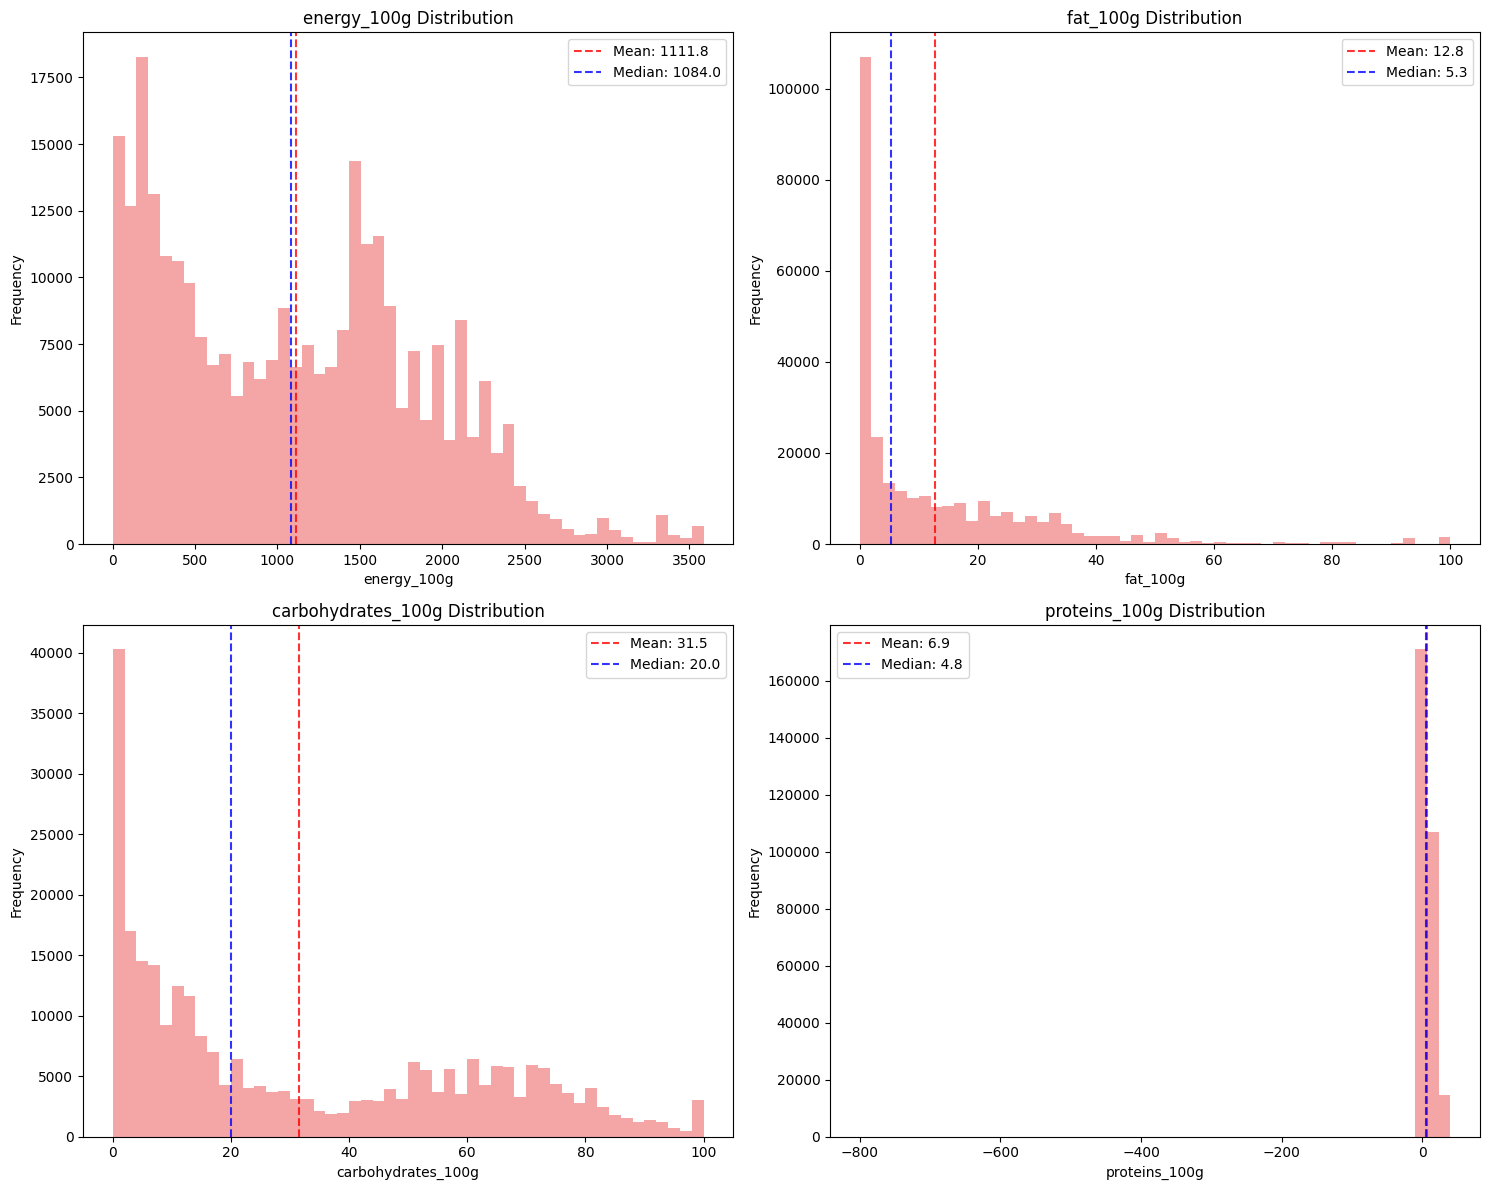

In [ ]:
# 4. Visualizing Distributions of Key Nutrients
print("\n📊 Step 4. KEY NUTRITIONAL DISTRIBUTIONS")
print("-"*50)

# Select key nutrients
key_nutrients = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g',
                 'sugars_100g', 'fiber_100g', 'salt_100g', 'sodium_100g']

available_nutrients = [col for col in key_nutrients if col in df.columns]
print(f"Available key nutrients: {available_nutrients}")

if len(available_nutrients) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, nutrient in enumerate(available_nutrients[:4]):
        # Remove outliers by limiting to the 99.5th percentile
        data_clean = df[nutrient].dropna()
        if len(data_clean) > 0:
            upper_limit = data_clean.quantile(0.995)
            data_plot = data_clean[data_clean <= upper_limit]

            axes[i].hist(data_plot, bins=50, alpha=0.7, color='lightcoral')
            axes[i].set_title(f'{nutrient} Distribution', fontsize=12)
            axes[i].set_xlabel(nutrient)
            axes[i].set_ylabel('Frequency')

            # Add statistics
            mean_val = data_plot.mean()
            median_val = data_plot.median()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.1f}')
            axes[i].axvline(median_val, color='blue', linestyle='--', alpha=0.8, label=f'Median: {median_val:.1f}')
            axes[i].legend()

    plt.tight_layout()
    plt.show()

##**Step 5. Nutri-Score vs Nutritional Content**

**Objective:** Examine how nutritional content varies across different Nutri-Score grades.

**Actions performed:**

* Calculate average nutrient values (energy, fat, carbs, protein) for each Nutri-Score grade.

* Visualize distributions with boxplots to identify patterns and outliers.


🔍 Step 5. NUTRI-SCORE vs NUTRITIONAL CONTENT
--------------------------------------------------
Average nutritional content by Nutri-Score:
                    energy_100g  fat_100g  carbohydrates_100g  proteins_100g
nutrition_grade_fr                                                          
a                        728.26      2.82               28.57           8.44
b                        517.78      3.90               17.35           5.23
c                        989.95      9.86               30.57           6.98
d                       1469.46     17.84               39.72           8.63
e                       1793.97     26.43               38.63           8.89


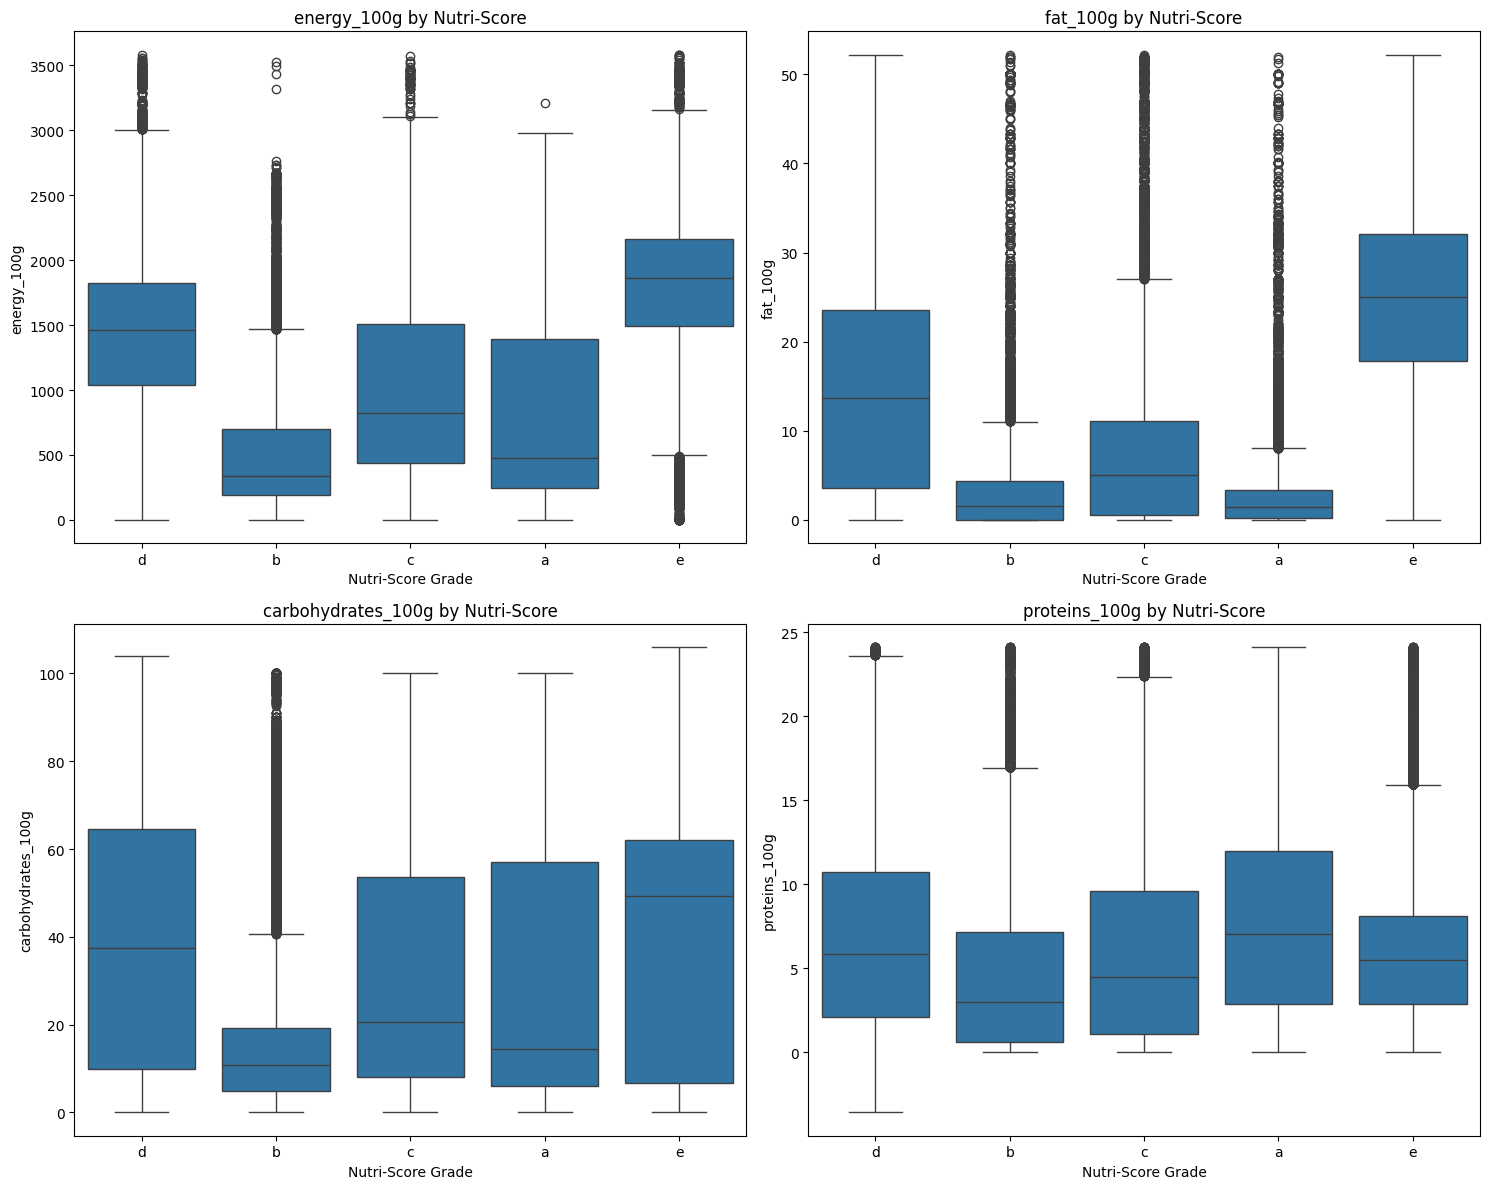

In [ ]:
# 5. Nutri-Score vs Nutritional Content
print("\n🔍 Step 5. NUTRI-SCORE vs NUTRITIONAL CONTENT")
print("-"*50)

if 'nutrition_grade_fr' in df.columns and available_nutrients:
    # Average nutrient values for each Nutri-Score grade
    nutri_stats = df.groupby('nutrition_grade_fr')[available_nutrients[:4]].mean()
    print("Average nutritional content by Nutri-Score:")
    print(nutri_stats.round(2))

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, nutrient in enumerate(available_nutrients[:4]):
        # Compare distribution using box plots
        df_clean = df.dropna(subset=['nutrition_grade_fr', nutrient])

        if len(df_clean) > 0:
            # Remove outliers
            Q1 = df_clean[nutrient].quantile(0.25)
            Q3 = df_clean[nutrient].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR

            df_plot = df_clean[df_clean[nutrient] <= upper_bound]

            sns.boxplot(data=df_plot, x='nutrition_grade_fr', y=nutrient, ax=axes[i])
            axes[i].set_title(f'{nutrient} by Nutri-Score', fontsize=12)
            axes[i].set_xlabel('Nutri-Score Grade')
            axes[i].set_ylabel(nutrient)

    plt.tight_layout()
    plt.show()



##**Step 6. Missing Data Patterns in Nutritional Features**

**Objective:** Investigate missing data patterns within the main nutritional columns.

**Actions performed:**

* Create a summary table showing the count and percentage of missing values (top 20 nutrition features).

* Generate a heatmap (sample of 1,000 rows) to visualize where missingness occurs.


❓ Step 6. MISSING DATA PATTERNS
--------------------------------------------------
Missing data in nutrition columns (top 20, sorted by completeness):
                      Column  Missing_Count  Missing_Percentage
0                energy_100g          60660               17.04
13             proteins_100g          61866               17.38
15                 salt_100g          66288               18.62
16               sodium_100g          66333               18.63
2                   fat_100g          76530               21.50
10        carbohydrates_100g          76807               21.57
11               sugars_100g          76841               21.58
3         saturated-fat_100g          92204               25.90
12                fiber_100g         135344               38.02
9             trans-fat_100g         212584               59.71
17            vitamin-a_100g         218321               61.32
5   polyunsaturated-fat_100g         332952               93.52
4   monounsatura

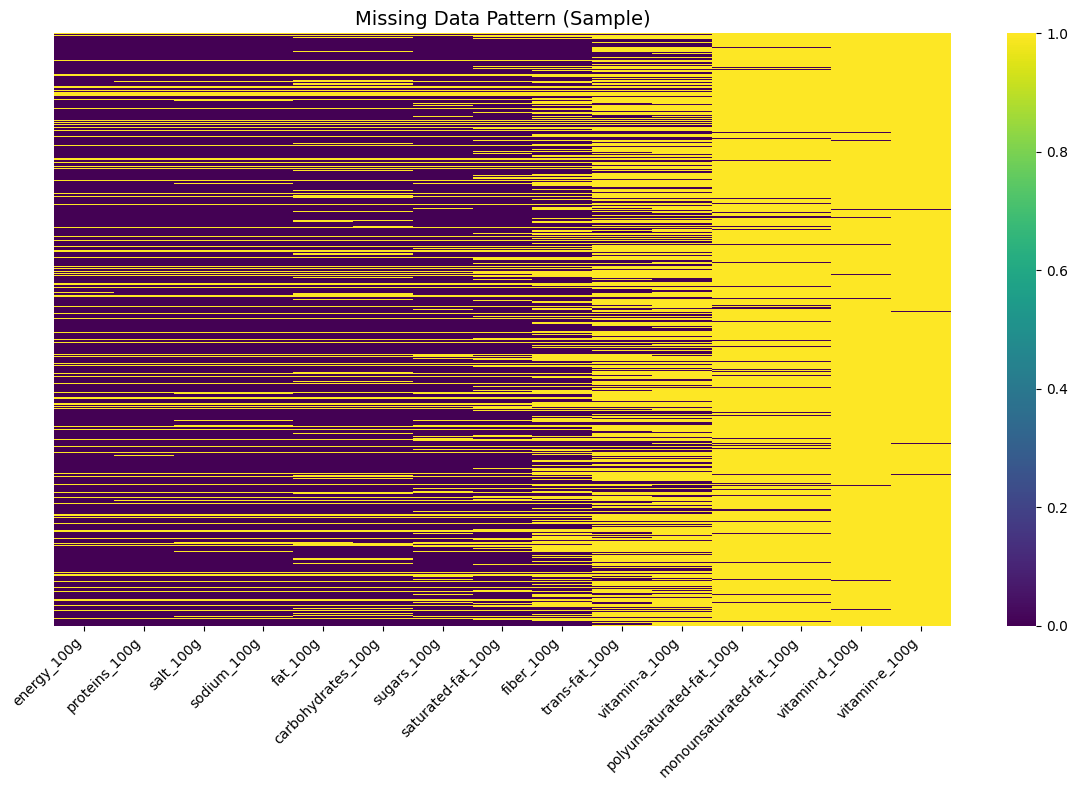

In [ ]:
# Step 6. Missing Data Patterns
print("\n❓ Step 6. MISSING DATA PATTERNS")
print("-"*50)

# Analyze missing data in nutritional columns
if main_nutrition_cols:
    missing_analysis = pd.DataFrame({
        'Column': main_nutrition_cols[:20],  # Only top 20
        'Missing_Count': [df[col].isna().sum() for col in main_nutrition_cols[:20]],
        'Missing_Percentage': [(df[col].isna().sum() / len(df)) * 100 for col in main_nutrition_cols[:20]]
    }).sort_values('Missing_Percentage', ascending=True)

    print("Missing data in nutrition columns (top 20, sorted by completeness):")
    print(missing_analysis.round(2))

    # Missing value heatmap (top 15 columns with least missing data)
    plt.figure(figsize=(12, 8))
    top_complete_cols = missing_analysis.head(15)['Column'].tolist()

    # Sample for heatmap (entire dataset may be too large)
    sample_size = min(1000, len(df))
    df_sample = df[top_complete_cols].sample(n=sample_size, random_state=42)

    sns.heatmap(df_sample.isna(), cbar=True, yticklabels=False,
                xticklabels=True, cmap='viridis')
    plt.title('Missing Data Pattern (Sample)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

##**Step 7. Basic Statistical Summary of Key Nutrients**

**Objective:** Provide a statistical overview of the key nutritional features and explore their interrelationships.

**Actions performed:**

* Generate descriptive statistics (mean, std, min, max, quartiles) for the selected nutrient columns.

* Compute and display the correlation matrix to identify linear relationships among nutrients.




📋 Step 7. STATISTICAL SUMMARY
--------------------------------------------------
Descriptive statistics for key nutrients:
       energy_100g      fat_100g  carbohydrates_100g  proteins_100g  \
count    295367.00  2.794970e+05        2.792200e+05   2.941610e+05   
mean       1125.45  5.606587e+04        5.614020e+04   5.326598e+04   
std         936.83  2.963385e+07        2.964854e+07   2.888578e+07   
min           0.00  0.000000e+00        0.000000e+00  -8.000000e+02   
25%         382.00  1.000000e-01        5.600000e+00   7.200000e-01   
50%        1092.00  5.290000e+00        2.000000e+01   4.880000e+00   
75%        1674.00  2.000000e+01        5.758000e+01   1.000000e+01   
max      231199.00  1.566667e+10        1.566667e+10   1.566667e+10   

       sugars_100g    fiber_100g  salt_100g  sodium_100g  
count    279186.00  2.206830e+05  289739.00    289694.00  
mean         15.67  3.843467e+05       1.94         0.76  
std          21.98  1.805529e+08     120.55        47.46  


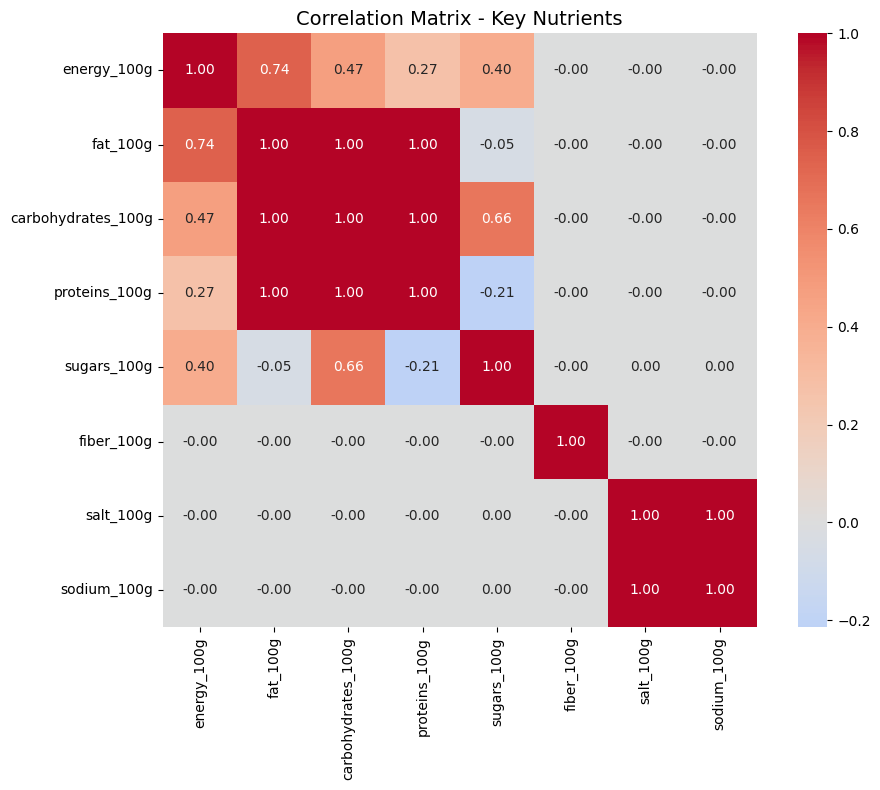

In [ ]:
# Step 7. Basic Statistical Summary
print("\n📋 Step 7. STATISTICAL SUMMARY")
print("-"*50)

if available_nutrients:
    print("Descriptive statistics for key nutrients:")
    stats_df = df[available_nutrients].describe()
    print(stats_df.round(2))

    # Correlation analysis
    if len(available_nutrients) > 1:
        print(f"\nCorrelation matrix for nutrients:")
        corr_matrix = df[available_nutrients].corr()
        print(corr_matrix.round(3))

        # Correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.2f')
        plt.title('Correlation Matrix - Key Nutrients', fontsize=14)
        plt.tight_layout()
        plt.show()

##**Step 8. Data Quality Assessment & Final EDA Summary**

**Objective:** Evaluate the dataset’s readiness for predictive modeling by checking the availability of the target variable and completeness of key features.

**Key Findings:**

* Percentage of samples with a valid Nutri-Score (target variable).

* Percentage of samples with complete nutritional information across selected key nutrients.

* Percentage of samples that have both the target and the top 4 nutrient values, which are crucial for machine learning tasks.

In [ ]:
# 8. Data Quality Assessment
print("\n🎯 8. DATA QUALITY ASSESSMENT")
print("-"*50)

# Number of samples with target variable
if 'nutrition_grade_fr' in df.columns:
    target_available = df['nutrition_grade_fr'].notna().sum()
    print(f"Samples with Nutri-Score: {target_available:,} ({target_available/len(df)*100:.1f}%)")

# Number of samples with complete nutrition info
if available_nutrients:
    complete_nutrition = df[available_nutrients].dropna().shape[0]
    print(f"Samples with complete nutrition info: {complete_nutrition:,} ({complete_nutrition/len(df)*100:.1f}%)")

# Number of samples with both target and top 4 nutrient values
if 'nutrition_grade_fr' in df.columns and available_nutrients:
    complete_for_ml = df.dropna(subset=['nutrition_grade_fr'] + available_nutrients[:4]).shape[0]
    print(f"Samples ready for ML (target + top 4 nutrients): {complete_for_ml:,} ({complete_for_ml/len(df)*100:.1f}%)")

# Final summary
print(f"\n✅ EDA Complete! Dataset overview:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Total features: {len(df.columns)}")
print(f"   • Nutrition features: {len(main_nutrition_cols)}")
print(f"   • Target variable: {'✅' if 'nutrition_grade_fr' in df.columns else '❌'}")


🎯 8. DATA QUALITY ASSESSMENT
--------------------------------------------------
Samples with Nutri-Score: 254,856 (71.6%)
Samples with complete nutrition info: 201,141 (56.5%)
Samples ready for ML (target + top 4 nutrients): 238,533 (67.0%)

✅ EDA Complete! Dataset overview:
   • Total samples: 356,027
   • Total features: 163
   • Nutrition features: 29
   • Target variable: ✅


#**Part II: Feature Engineering (OFF Data)**


**Actions performed:**

**1. Column Selection**


*   Selected relevant nutritional features (energy, fat, carbohydrates, proteins, etc.)
*   Included product characteristics (additives, ingredients count, etc.)
*   Preserved metadata for country-level aggregation

**2. Target Variable Encoding**

*   Encoded Nutri-Score grades (a-e) to ordinal values (0-4)
*   Preserved the ordinal nature of the grades (a=best=0, e=worst=4)

**3. Handling Missing Values & Encoding**

*   Numerical features: Used median imputation for macronutrients, zero imputation for counts
*   Non-numeric to numeric: Converted all relevant features to numerical format
*   Missing values: Applied appropriate imputation strategies based on feature type


**4. Feature Engineering**
Created several new features:
*   Nutritional ratios: fat_energy_ratio, protein_energy_ratio, sugar_carb_ratio
*   Health indicators: high_fiber, high_protein, low_salt, low_sugar
*   Energy density categories: Categorized products by energy content
*   Country/category counts: Number of countries/categories per product

In [5]:
# =====================================================
# STEP 1: FEATURE SELECTION & ENGINEERING
# =====================================================

# 1.1 Select relevant columns
print("\n1. SELECTING RELEVANT COLUMNS")
print("="*50)

# Target variable
target_col = 'nutrition_grade_fr'

# Core nutritional features (per 100g)
nutrition_features = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'
]

# Additional nutritional features if available
additional_nutrition = [
    'trans-fat_100g', 'cholesterol_100g', 'vitamin-a_100g', 'vitamin-c_100g',
    'calcium_100g', 'iron_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g'
]

# Product characteristic features
product_features = [
    'additives_n', 'ingredients_n', 'ingredients_from_palm_oil_n',
    'ingredients_that_may_be_from_palm_oil_n', 'nova_group',
    'pnns_groups_1', 'pnns_groups_2'
]

# Metadata features (for aggregation and analysis)
metadata_features = ['code', 'product_name', 'brands', 'categories', 'countries']

# Combine all features
all_features = metadata_features + [target_col] + nutrition_features + additional_nutrition + product_features

# Filter to only existing columns
existing_features = [col for col in all_features if col in df.columns]
df_selected = df[existing_features].copy()

print(f"Selected {len(existing_features)} features from {len(df.columns)} total")
print(f"Missing target column: {target_col not in df.columns}")

# display first 5 rows of selected columns data
df_selected.head(5)


1. SELECTING RELEVANT COLUMNS
Selected 28 features from 163 total
Missing target column: False


,code,product_name,brands,categories,countries,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,...,vitamin-c_100g,calcium_100g,iron_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,pnns_groups_1,pnns_groups_2
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,NaN,en:FR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,US,d,2243.0,28.57,28.57,64.29,...,0.0214,0.000,0.00129,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2,0000000004559,Peanuts,Torn & Glasser,NaN,US,b,1941.0,17.86,0.00,60.71,...,0.0000,0.071,0.00129,NaN,NaN,0.0,0.0,0.0,NaN,NaN
3,0000000016087,Organic Salted Nut Mix,Grizzlies,NaN,US,d,2540.0,57.14,5.36,17.86,...,NaN,0.143,0.00514,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4,0000000016094,Organic Polenta,Bob's Red Mill,NaN,US,NaN,1552.0,1.43,NaN,77.14,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN


In [6]:
# =====================================================
# STEP 2: ENCODE TARGET VARIABLE
# =====================================================

print("\n2. ENCODING TARGET VARIABLE")
print("="*50)

if target_col in df_selected.columns:
    # Nutri-Score: a (best) to e (worst)
    # Ordinal encoding: a=0, b=1, c=2, d=3, e=4
    nutri_score_mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}

    print("Original target distribution:")
    print(df_selected[target_col].value_counts(dropna=False).sort_index())

    # Create encoded target
    df_selected['nutrition_grade_encoded'] = df_selected[target_col].map(nutri_score_mapping)

    print("\nEncoded target distribution:")
    print(df_selected['nutrition_grade_encoded'].value_counts(dropna=False).sort_index())

    # Calculate encoding success rate
    encoded_count = df_selected['nutrition_grade_encoded'].notna().sum()
    total_count = len(df_selected)
    print(f"\nSuccessfully encoded: {encoded_count}/{total_count} ({encoded_count/total_count*100:.1f}%)")


2. ENCODING TARGET VARIABLE
Original target distribution:
nutrition_grade_fr
a       40304
b       39010
c       52870
d       72436
e       50236
NaN    101171
Name: count, dtype: int64

Encoded target distribution:
nutrition_grade_encoded
0.0     40304
1.0     39010
2.0     52870
3.0     72436
4.0     50236
NaN    101171
Name: count, dtype: int64

Successfully encoded: 254856/356027 (71.6%)


In [7]:
# =====================================================
# STEP 3: DATA CLEANING & ENCODING
# =====================================================

print("\n3. DATA CLEANING & ENCODING")
print("="*50)

from sklearn.preprocessing import LabelEncoder

# 3.1 Handle missing values in numerical features
numerical_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {len(numerical_cols)}")

# For nutritional data, we'll use different strategies:
# - For macronutrients (energy, fat, carbs, protein): median imputation
# - For micronutrients: 0 (assuming not measured means negligible)
# - For counts (additives, ingredients): 0

macro_nutrients = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']
micro_nutrients = [col for col in numerical_cols if 'vitamin' in col or 'calcium' in col or 'iron' in col]
count_features = [col for col in numerical_cols if '_n' in col]

# Impute macronutrients with median
for col in macro_nutrients:
    if col in df_selected.columns:
        median_val = df_selected[col].median()
        df_selected[col].fillna(median_val, inplace=True)
        print(f"Imputed {col} with median: {median_val:.2f}")

# Impute micronutrients and counts with 0
for col in micro_nutrients + count_features:
    if col in df_selected.columns:
        df_selected[col].fillna(0, inplace=True)

# 3.2 Create engineered features
print("\n3.2 Creating engineered features...")

# Nutritional ratios
if 'fat_100g' in df_selected.columns and 'energy_100g' in df_selected.columns:
    df_selected['fat_energy_ratio'] = (df_selected['fat_100g'] * 9) / df_selected['energy_100g'].replace(0, 1) * 100

if 'proteins_100g' in df_selected.columns and 'energy_100g' in df_selected.columns:
    df_selected['protein_energy_ratio'] = (df_selected['proteins_100g'] * 4) / df_selected['energy_100g'].replace(0, 1) * 100

if 'sugars_100g' in df_selected.columns and 'carbohydrates_100g' in df_selected.columns:
    df_selected['sugar_carb_ratio'] = df_selected['sugars_100g'] / df_selected['carbohydrates_100g'].replace(0, 1)

if 'saturated-fat_100g' in df_selected.columns and 'fat_100g' in df_selected.columns:
    df_selected['saturated_fat_ratio'] = df_selected['saturated-fat_100g'] / df_selected['fat_100g'].replace(0, 1)

# Binary health indicators
if 'fiber_100g' in df_selected.columns:
    df_selected['high_fiber'] = (df_selected['fiber_100g'] > 3).astype(int)

if 'proteins_100g' in df_selected.columns:
    df_selected['high_protein'] = (df_selected['proteins_100g'] > 10).astype(int)

if 'salt_100g' in df_selected.columns:
    df_selected['low_salt'] = (df_selected['salt_100g'] < 0.3).astype(int)

if 'sugars_100g' in df_selected.columns:
    df_selected['low_sugar'] = (df_selected['sugars_100g'] < 5).astype(int)

# Energy density categories
if 'energy_100g' in df_selected.columns:
    df_selected['energy_density_category'] = pd.cut(
        df_selected['energy_100g'],
        bins=[0, 150, 250, 400, float('inf')],
        labels=['very_low', 'low', 'medium', 'high']
    )

# 3.3 Encode categorical variables
print("\n3.3 Encoding categorical variables...")

# Handle categorical features
categorical_cols = ['nova_group', 'pnns_groups_1', 'pnns_groups_2', 'energy_density_category']
categorical_cols = [col for col in categorical_cols if col in df_selected.columns]

for col in categorical_cols:
    # Convert to object type before filling NaN to avoid CategoricalDtype issues
    df_selected[col] = df_selected[col].astype(object)
    df_selected[col].fillna('unknown', inplace=True)

    le = LabelEncoder()
    df_selected[f'{col}_encoded'] = le.fit_transform(df_selected[col])
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Extract primary country for aggregation
if 'countries' in df_selected.columns:
    df_selected['country_primary'] = df_selected['countries'].fillna('unknown').str.split(',').str[0].str.strip()
    df_selected['country_count'] = df_selected['countries'].fillna('').str.split(',').apply(len)

# Extract primary category
if 'categories' in df_selected.columns:
    df_selected['category_primary'] = df_selected['categories'].fillna('unknown').str.split(',').str[0].str.strip()
    df_selected['category_count'] = df_selected['categories'].fillna('').str.split(',').apply(len)


3. DATA CLEANING & ENCODING
Numerical columns: 21
Imputed energy_100g with median: 1092.00
Imputed fat_100g with median: 5.29
Imputed carbohydrates_100g with median: 20.00
Imputed proteins_100g with median: 4.88

3.2 Creating engineered features...

3.3 Encoding categorical variables...
Encoded pnns_groups_1: 14 unique values
Encoded pnns_groups_2: 42 unique values
Encoded energy_density_category: 5 unique values


In [8]:
# =====================================================
# STEP 4: PREPARE FEATURE MATRIX
# =====================================================

print("\n4. PREPARING FEATURE MATRIX")
print("="*50)

# Select final features for ML
feature_cols = []

# Numerical features
num_features = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
    'additives_n', 'ingredients_n', 'ingredients_from_palm_oil_n',
    'fat_energy_ratio', 'protein_energy_ratio', 'sugar_carb_ratio', 'saturated_fat_ratio',
    'high_fiber', 'high_protein', 'low_salt', 'low_sugar', 'country_count', 'category_count'
]
feature_cols.extend([col for col in num_features if col in df_selected.columns])

# Encoded categorical features
encoded_features = [col for col in df_selected.columns if col.endswith('_encoded') and col != 'nutrition_grade_encoded']
feature_cols.extend(encoded_features)

# Remove duplicates
feature_cols = list(dict.fromkeys(feature_cols))

print(f"Total features for ML: {len(feature_cols)}")
print("Feature categories:")
print(f"- Nutritional: {len([f for f in feature_cols if '100g' in f])}")
print(f"- Ratios: {len([f for f in feature_cols if 'ratio' in f])}")
print(f"- Binary indicators: {len([f for f in feature_cols if f.startswith('high_') or f.startswith('low_')])}")
print(f"- Encoded categories: {len([f for f in feature_cols if f.endswith('_encoded')])}")
print(f"- Other: {len([f for f in feature_cols if '_n' in f or '_count' in f])}")

# Create feature matrix
X = df_selected[feature_cols].copy()

# Final check for missing values
missing_per_feature = X.isnull().sum()
if missing_per_feature.sum() > 0:
    # Fill remaining NaN with 0
    X = X.fillna(0)

# Get target variable
if 'nutrition_grade_encoded' in df_selected.columns:
    y = df_selected['nutrition_grade_encoded'].copy()
    # Remove samples with missing target
    mask = y.notna()
    X = X[mask]
    y = y[mask]
    print(f"\nFinal dataset: {X.shape[0]} samples, {X.shape[1]} features")
else:
    y = None
    print("\nWarning: No target variable available")


4. PREPARING FEATURE MATRIX
Total features for ML: 24
Feature categories:
- Nutritional: 9
- Ratios: 4
- Binary indicators: 4
- Encoded categories: 3
- Other: 4

Final dataset: 254856 samples, 24 features


In [9]:
# =====================================================
# STEP 5: DATA QUALITY SUMMARY
# =====================================================

print("\n5. DATA QUALITY SUMMARY")
print("="*50)

print(f"\nOriginal dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"After feature selection: {df_selected.shape[0]} rows × {df_selected.shape[1]} columns")
print(f"Final feature matrix: {X.shape[0]} rows × {X.shape[1]} features")

if y is not None:
    print(f"\nTarget variable distribution:")
    target_dist = pd.Series(y).value_counts().sort_index()
    for grade, count in target_dist.items():
        grade_letter = ['A', 'B', 'C', 'D', 'E'][int(grade)]
        print(f"  Grade {grade_letter}: {count} ({count/len(y)*100:.1f}%)")

print("\nFeature types summary:")
feature_summary = pd.DataFrame({
    'Feature': feature_cols,
    'Type': ['Numerical' if X[col].dtype in ['float64', 'int64'] else 'Categorical' for col in feature_cols],
    'Missing_Pct': [0] * len(feature_cols),  # After imputation
    'Unique_Values': [X[col].nunique() for col in feature_cols]
})

print(feature_summary.groupby('Type').size())



5. DATA QUALITY SUMMARY

Original dataset: 356027 rows × 163 columns
After feature selection: 356027 rows × 45 columns
Final feature matrix: 254856 rows × 24 features

Target variable distribution:
  Grade A: 40304 (15.8%)
  Grade B: 39010 (15.3%)
  Grade C: 52870 (20.7%)
  Grade D: 72436 (28.4%)
  Grade E: 50236 (19.7%)

Feature types summary:
Type
Numerical    24
dtype: int64


In [10]:
# =====================================================
# STEP 6: SAVE PROCESSED DATA
# =====================================================

print("\n6. SAVING PROCESSED DATA")
print("="*50)

# Create a dictionary with all processed data
processed_data = {
    'X': X,  # Feature matrix
    'y': y,  # Target variable (encoded)
    'feature_names': feature_cols,  # List of feature names
    'df_processed': df_selected,  # Full processed dataframe
    'df_country_aggregated': df_country_aggregated if 'df_country_aggregated' in locals() else None,
    'target_mapping': {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # For reference
}

print("Processed data components:")
print(f"- X: {processed_data['X'].shape}")
print(f"- y: {processed_data['y'].shape if processed_data['y'] is not None else 'None'}")
print(f"- feature_names: {len(processed_data['feature_names'])} features")
print(f"- df_processed: {processed_data['df_processed'].shape}")


6. SAVING PROCESSED DATA
Processed data components:
- X: (254856, 24)
- y: (254856,)
- feature_names: 24 features
- df_processed: (356027, 45)


#**Part III: Machine Learning Model**

##**Step 1. Data Preprocessing for machine learning model**
* Splitting the entire dataset into Training set and Testing set

In [ ]:
# =============================================================================
# Step 1: Splitting data in test and training set
# =============================================================================

#Create train (80%) and test (20%) set for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

##**Step 2. Machine Model Selection**
Model selected are for supervised classification problem. They are scale invariant, hence normalization is not required.
* Decision Tree
* Random Forest
* Extreme Gradient Boosting

Selection of best model based on the following metrics:
* Accuracy
* ROC - AUC


###**Step 2.1. Decision Tree Model**
Decision trees are a class of non-parametric algorithms that are used supervised learning problems: Classification and Regression.
https://en.wikiversity.org/wiki/Machine_learning/Supervised_Learning/Decision_Trees

In [ ]:
# =============================================================================
# Step 2: Running first machine learning model - Decision Tree
# =============================================================================

#Storing all results from the 3 models
results = []
#Training Decision Tree model
print("Running the decision tree model... (this may take some time)")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
#Train the model
dt_model.fit(X_train, y_train)
#Predict on training and test set
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)

#Calculate evaluation metrics for training set: accuracy score
accuracy_train_dt = accuracy_score(y_train, y_pred_dt_train)

#Calculate evaluation metrics for test set: accuracy score
accuracy_test_dt = accuracy_score(y_test, y_pred_dt_test)

#Calculate the ROC-AUC One vs rest
y_pred_prob_dt = dt_model.predict_proba(X_test)
roc_auc_dt_ovr = roc_auc_score(y_test, y_pred_prob_dt, multi_class='ovr', average='macro')

#Conduct cross-validation using accuracy on training model; 5 folds
cv_scores_dt = cross_val_score(dt_model, X_train, y_train, scoring='accuracy', cv=5)
cv_mean_dt = cv_scores_dt.mean()
cv_std_dt = cv_scores_dt.std()

#Storing the results
results.append({
      'Model':'Decision_Tree',
      'Test_Accuracy': accuracy_test_dt,
      'Training_Accuracy': accuracy_train_dt,
      'ROC_AUC_OVR':roc_auc_dt_ovr,
      'CV_accuracy_mean': cv_mean_dt,
      'CV_accuracy_std': cv_std_dt
})

print(f"The Decision Tree Test accuracy is {accuracy_test_dt:.4f}")
print(f"The Decision Tree ROC AUC is {roc_auc_dt_ovr:.4f}")

Running the decision tree model... (this may take some time)
The Decision Tree Test accuracy is 0.8669
The Decision Tree ROC AUC is 0.9745


###**Step 2.2. Random Forest Model**
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# =============================================================================
# Step 3: Running second machine learning model - Random Forest
# =============================================================================

#Training Random Forest model
print("Running the random forest model... (this may take some time)")
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=10)
#Train the model
rf_model.fit(X_train, y_train)
#Predict on training and test set
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

#Calculate evaluation metrics for training set: accuracy score
accuracy_train_rf = accuracy_score(y_train, y_pred_rf_train)

#Calculate evaluation metrics for test set: accuracy score
accuracy_test_rf = accuracy_score(y_test, y_pred_rf_test)

#Calculate the ROC-AUC One vs rest
y_pred_prob_rf = rf_model.predict_proba(X_test)
roc_auc_rf_ovr = roc_auc_score(y_test, y_pred_prob_rf, multi_class='ovr', average='macro')

#Conduct cross-validation using accuracy on training model; 5 folds
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, scoring='accuracy', cv=5)
cv_mean_rf = cv_scores_rf.mean()
cv_std_rf = cv_scores_rf.std()

#Storing the results
results.append({
      'Model':'Random_Forest',
      'Test_Accuracy': accuracy_test_rf,
      'Training_Accuracy': accuracy_train_rf,
      'ROC_AUC_OVR':roc_auc_rf_ovr,
      'CV_accuracy_mean': cv_mean_rf,
      'CV_accuracy_std': cv_std_rf
})

print(f"The Random Forest Test accuracy is {accuracy_test_rf:.4f}")
print(f"The Random Forest ROC AUC is {roc_auc_rf_ovr:.4f}")

Running the random forest model... (this may take some time)
The Random Forest Test accuracy is 0.8763
The Random Forest ROC AUC is 0.9845


###**Step 2.3. Extreme Gradient Boosting**
XGBoost is an ensemble learning and a gradient boosting algorithm for decision trees that uses a second-order approximation of the scoring function. This approximation allows XGBoost to calculate the optimal “if” condition and its impact on performance. XGBoost can then store these in its memory in the next decision tree to save recomputing it.

https://wiki.datrics.ai/xgboost-classification

In [ ]:
# =============================================================================
# Step 4: Running third machine learning model - XGBoost
# =============================================================================

#Training XGBoost model
print("Running the XGBoost model... (this may take some time)")
xgb_model = XGBClassifier(n_estimators=20, random_state=42, max_depth=10, learning_rate=0.1, objective='multi;softprob', eval_metric='mlogloss', use_label_encoder=False)
#Train the model
xgb_model.fit(X_train, y_train)
#Predict on training and test set
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

#Calculate evaluation metrics for training set: accuracy score
accuracy_train_xgb = accuracy_score(y_train, y_pred_xgb_train)

#Calculate evaluation metrics for test set: accuracy score
accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb_test)

#Calculate the ROC-AUC One vs rest
y_pred_prob_xgb = xgb_model.predict_proba(X_test)
roc_auc_xgb_ovr = roc_auc_score(y_test, y_pred_prob_xgb, multi_class='ovr', average='macro')

#Conduct cross-validation using accuracy on training model; 5 folds
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, scoring='accuracy', cv=5)
cv_mean_xgb = cv_scores_xgb.mean()
cv_std_xgb = cv_scores_xgb.std()

#Storing the results
results.append({
      'Model':'XGBoost',
      'Test_Accuracy': accuracy_test_xgb,
      'Training_Accuracy': accuracy_train_xgb,
      'ROC_AUC_OVR':roc_auc_xgb_ovr,
      'CV_accuracy_mean': cv_mean_xgb,
      'CV_accuracy_std': cv_std_xgb
})

print(f"The XGBoost Test accuracy is {accuracy_test_xgb:.4f}")
print(f"The XGBoost ROC AUC is {roc_auc_xgb_ovr:.4f}")

Running the XGBoost model... (this may take some time)
The XGBoost Test accuracy is 0.9384
The XGBoost ROC AUC is 0.9945


###**Step 2.4. Models comparison**
Compare the performances of each models, using metrics defined previously:
* Test Accuracy score
* ROC- AUC
* Training Accuracy score to determine underfitting or overfitting

Model Performance Summary
           Model  Test_Accuracy  Training_Accuracy  ROC_AUC_OVR  \
0  Decision_Tree         0.8669             0.8762       0.9745   
1  Random_Forest         0.8763             0.8878       0.9845   
2        XGBoost         0.9384             0.9560       0.9945   

   CV_accuracy_mean  CV_accuracy_std  
0            0.8662           0.0023  
1            0.8769           0.0033  
2            0.9363           0.0014  


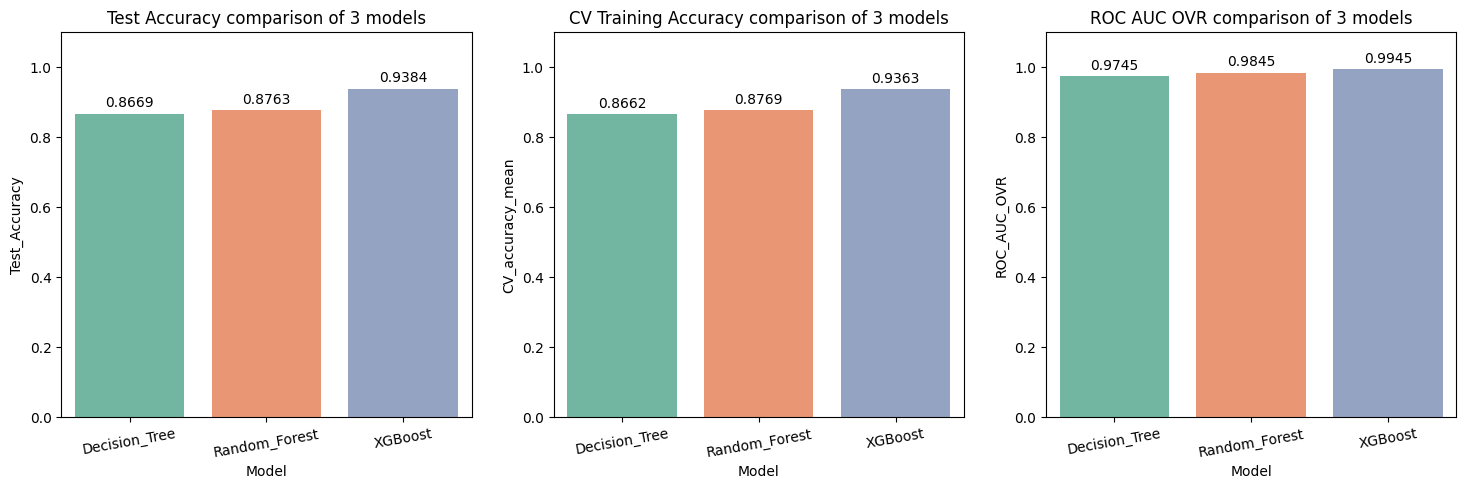

In [ ]:
# =============================================================================
# Step 5: Models comparison and selection of best performing model
# =============================================================================

#Create dataframe to compare model performance
results_df = pd.DataFrame(results).round(4)
print("Model Performance Summary")
print(results_df)
#Plot visualization of the 3 models
fig, axes = plt.subplots(1,3, figsize=(18,5))
#Plot on Test Accuracy
sns.barplot(ax=axes[0], data=results_df, x='Model',y='Test_Accuracy', palette='Set2')
axes[0].set_title("Test Accuracy comparison of 3 models")
axes[0].set_ylim(0,1.1)
axes[0].tick_params(axis='x', rotation=10)
for i, val in enumerate(results_df["Test_Accuracy"]):
  axes[0].text(i, val + 0.01, f"{val:.4f}", ha="center", va="bottom")

#Plot on CV Training Accuracy
sns.barplot(ax=axes[1], data=results_df, x='Model',y='CV_accuracy_mean', palette='Set2')
axes[1].set_title("CV Training Accuracy comparison of 3 models")
axes[1].set_ylim(0,1.1)
axes[1].tick_params(axis='x', rotation=10)
for i, val in enumerate(results_df["CV_accuracy_mean"]):
  axes[1].text(i, val + 0.01, f"{val:.4f}", ha="center", va="bottom")

#Plot on ROC AUC OvR
sns.barplot(ax=axes[2], data=results_df, x='Model',y='ROC_AUC_OVR', palette='Set2')
axes[2].set_title("ROC AUC OVR comparison of 3 models")
axes[2].set_ylim(0,1.1)
axes[2].tick_params(axis='x', rotation=10)
for i, val in enumerate(results_df["ROC_AUC_OVR"]):
  axes[2].text(i, val + 0.01, f"{val:.4f}", ha="center", va="bottom")
plt.show()

In [ ]:
#Based on the comparison graphs above, we can interpret that the XGBoost model have the best performance among the 3 models in Test accuracy and also ROC AUC.

##**Step 3. Hyper Parameter Tuning**
Hyperparameters directly control model structure, function, and performance. Hyperparameter tuning allows data scientists to tweak model performance for optimal results.
* n_estimator
* learning_rate
* max_depth


Running the XGBoost model... (this may take some time est 6-7 mins)


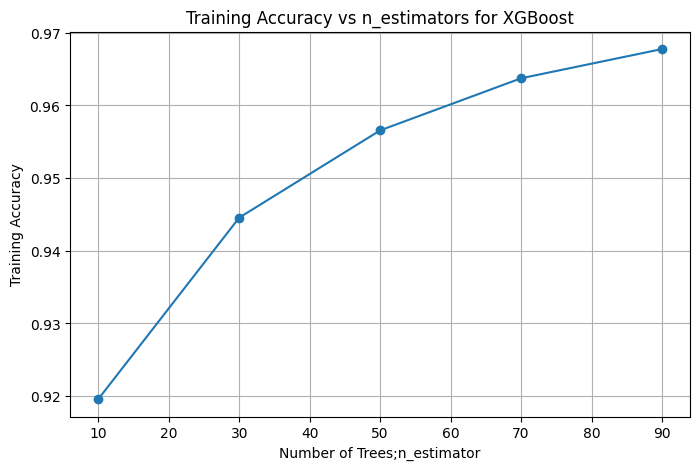

Best n_estimators is : 90
Best n_estimator Training accuracy is : 0.9677463654345376


In [ ]:
# =============================================================================
# Step 6: Hyperparamer tuning for best model performance
# =============================================================================

print("Running the XGBoost model... (this may take some time est 6-7 mins)")
#Finding the best n_estimator of XGBoost model
#Storing results of n_estimator
n_estimator_results = []

n_estimators_list = [10, 30, 50, 70, 90]

for n in n_estimators_list:
    xgb_model_estimator = XGBClassifier(n_estimators=n, max_depth=10,learning_rate=0.1,objective='multi:softprob',eval_metric='mlogloss',use_label_encoder=False,random_state=42)
    scores = cross_val_score(xgb_model_estimator, X_train, y_train, cv=3, scoring='accuracy')
    n_estimator_results.append(scores.mean())

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, n_estimator_results, marker='o')
plt.title("Training Accuracy vs n_estimators for XGBoost")
plt.xlabel("Number of Trees;n_estimator")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

best_n_estimators = n_estimators_list[np.argmax(n_estimator_results)]
print(f"Best n_estimators is : {best_n_estimators}")
print(f"Best n_estimator Training accuracy is : {max(n_estimator_results)}")

Running the XGBoost model... (this may take some time est 8-9 mins)


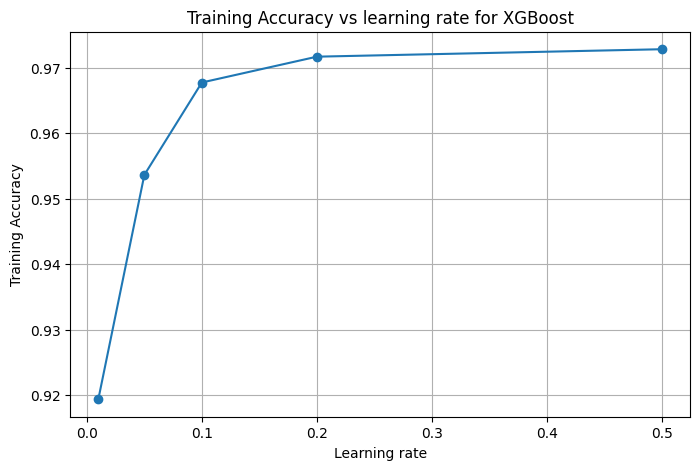

Best Learning rate is : 0.5
Best Learning rate Training accuracy is : 0.9728276872202248


In [ ]:
print("Running the XGBoost model... (this may take some time est 8-9 mins)")
#Finding the best learning rate of XGBoost model
#Storing results of learning rate
learning_rate_results = []
learning_rate_list = [0.01,0.05,0.1,0.2,0.5]
for n in learning_rate_list:
  xgb_model_learning = XGBClassifier(n_estimators=best_n_estimators, random_state=42, max_depth=10, learning_rate=n, objective='multi;softprob', eval_metric='mlogloss', use_label_encoder=False)
  scores = cross_val_score(xgb_model_learning, X_train, y_train, cv=3, scoring='accuracy')
  learning_rate_results.append(scores.mean())

plt.figure(figsize=(8,5))
plt.plot(learning_rate_list, learning_rate_results, marker='o')
plt.title("Training Accuracy vs learning rate for XGBoost")
plt.xlabel("Learning rate")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

best_learning_rate = learning_rate_list[learning_rate_results.index(max(learning_rate_results))]
print(f"Best Learning rate is : {best_learning_rate}")
print(f"Best Learning rate Training accuracy is : {max(learning_rate_results)}")

Running the XGBoost model... (this may take some time)


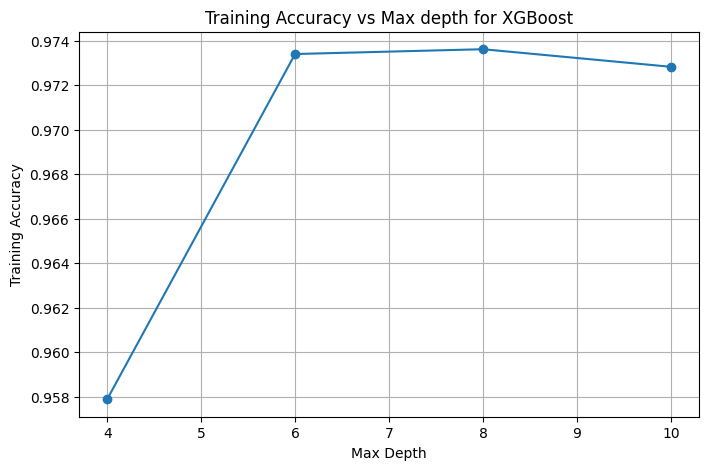

Best Learning rate is : 8
Best max_depth Training accuracy is : 0.9736173521961901


In [ ]:
print("Running the XGBoost model... (this may take some time)")
#Finding the best depth of XGBoost model
#Storing results of max_depth
max_depth_results = []
max_depth_range = range(4,11,2)
for n in max_depth_range:
  xgb_model_depth = XGBClassifier(n_estimators=best_n_estimators, random_state=42, max_depth=n, learning_rate=best_learning_rate, objective='multi;softprob', eval_metric='mlogloss', use_label_encoder=False)
  scores = cross_val_score(xgb_model_depth, X_train, y_train, cv=3, scoring='accuracy')
  max_depth_results.append(scores.mean())

plt.figure(figsize=(8,5))
plt.plot(max_depth_range, max_depth_results, marker='o')
plt.title("Training Accuracy vs Max depth for XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

best_max_depth = max_depth_range[max_depth_results.index(max(max_depth_results))]
print(f"Best Learning rate is : {best_max_depth}")
print(f"Best max_depth Training accuracy is : {max(max_depth_results)}")

##**Step 4. Run the Best model with Optimised Hyper parameters**

In [ ]:
# =============================================================================
# Step 7: Run Best machine learning model
# =============================================================================

#Storing final result from the best parameters on XGBoost model
final_results = []
#Training XGBoost model
print("Running the XGBoost model... (this may take some time)")
final_xgb_model = XGBClassifier(n_estimators=best_n_estimators, random_state=42, max_depth=best_max_depth, learning_rate=best_learning_rate, objective='multi;softprob', eval_metric='mlogloss', use_label_encoder=False)
#Train the model
final_xgb_model.fit(X_train, y_train)
#Predict on training and test set
y_pred_xgb_train = final_xgb_model.predict(X_train)
y_pred_xgb_test = final_xgb_model.predict(X_test)

#Calculate evaluation metrics for training set: accuracy score
accuracy_train_xgb_final = accuracy_score(y_train, y_pred_xgb_train)

#Calculate evaluation metrics for test set: accuracy score
accuracy_test_xgb_final = accuracy_score(y_test, y_pred_xgb_test)

#Calculate the ROC-AUC One vs rest
y_pred_prob_xgb_final = final_xgb_model.predict_proba(X_test)
roc_auc_xgb_ovr_final = roc_auc_score(y_test, y_pred_prob_xgb_final, multi_class='ovr', average='macro')

#Conduct cross-validation using accuracy on training model; 5 folds
cv_scores_xgb_final = cross_val_score(final_xgb_model, X_train, y_train, scoring='accuracy', cv=5)
cv_mean_xgb_final = cv_scores_xgb_final.mean()
cv_std_xgb_final = cv_scores_xgb_final.std()

#Storing the results
final_results.append({
      'Model':'XGBoost',
      'Test_Accuracy': accuracy_test_xgb_final,
      'Training_Accuracy': accuracy_train_xgb_final,
      'ROC_AUC_OVR':roc_auc_xgb_ovr_final,
      'CV_accuracy_mean': cv_mean_xgb_final,
      'CV_accuracy_std': cv_std_xgb_final
})

#Create dataframe to compare model performance
final_results_df = pd.DataFrame(final_results).round(4)
print("Model Performance Summary")
print(final_results_df)

Running the XGBoost model... (this may take some time)
Model Performance Summary
     Model  Test_Accuracy  Training_Accuracy  ROC_AUC_OVR  CV_accuracy_mean  \
0  XGBoost         0.9784             0.9995       0.9992            0.9765   

   CV_accuracy_std  
0           0.0009  


We have a equally balanced dataset with each class at around 15-28% (5 classes). To confirm that the model is not just biased toward any frequent class, we counter check with confusion matrix that the model is not bias.

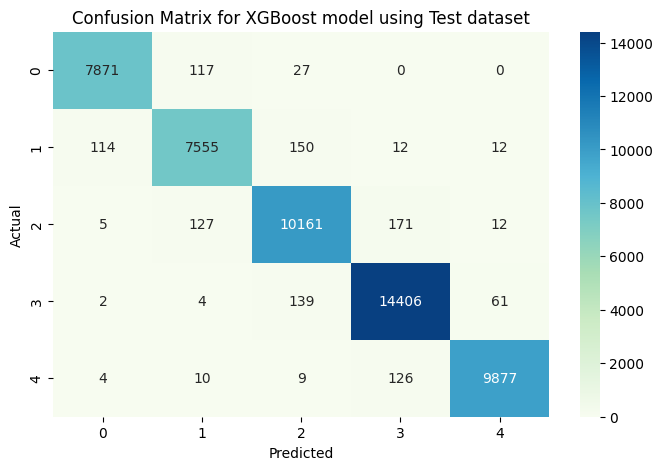

In [ ]:
#Confusion Matrix of the XGBoost model
label_map = {0:'A',1:'B',2:'C',3:'D',4:'E'}
labels = [label_map[i] for i in range(5)]
#Map numberic labels to Nutriscore grade
y_test_labels = [label_map[i] for i in y_test]
y_pred_labels = [label_map[i] for i in y_pred_xgb_test]

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True, fmt='g', cmap='GnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost model using Test dataset")
plt.show()

### **STEP 4.1: Find the top 10 most importance contributing features from the best model**



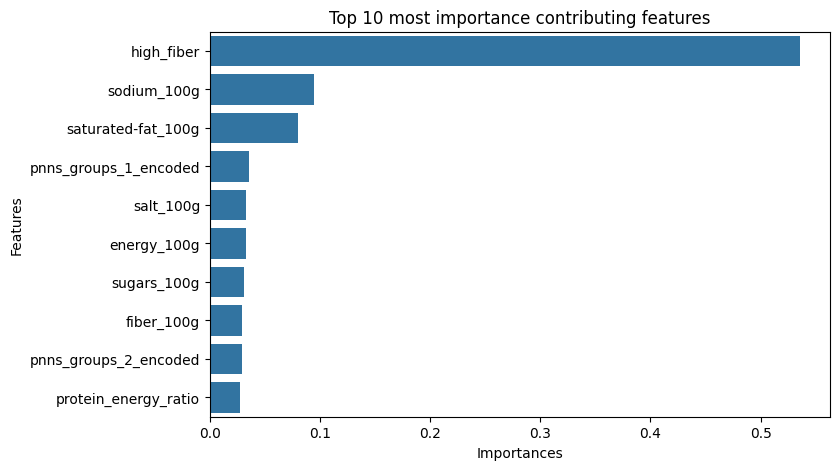

In [ ]:
importances = final_xgb_model.feature_importances_
feature_names = X_train.columns
features_importance_df = pd.DataFrame({
    'Features':feature_names,
    'Importances':importances
}).sort_values(by='Importances', ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(data=features_importance_df.head(10),x='Importances', y='Features')
plt.title("Top 10 most importance contributing features")
plt.show()



---



#**Part IV: Data Integration and Advanced Analysis**




### **Data Integration Objective**

#### **Research Exploration Focus:**


- By integrating Open Food Facts (OFF) data with World Bank (WB) socioeconomic and health indicators, this second part enables exploration of country similarities and patterns. The analysis examines how countries cluster based on wealth, food quality profiles, and market structures, identifying nations with comparable development-nutrition patterns.

- **Additionally,** this analysis provides a data-driven framework for **identifying optimal candidates for Nutri-Score system** adoption by evaluating countries based on economic readiness, health need and market characteristics. The integration assesses which countries share similar profiles to successful Nutri-Score adopters (France, Belgium) and identifies nations where nutritional labeling interventions would have the greatest public health impact, with particular focus on countries experiencing high obesity rates combined with large processed food markets such as United States.


- - -

#### **The integration also addresses some key analytical gaps:**

- **Contextualizing Food Data:** Raw food product information gains meaning when viewed against economic development, health outcomes, and social inequality metrics
- **Data Quality Assessment:** The merger reveals significant limitations in OFF's global coverage and inherent biases toward wealthier nations



### **Step 1. Fetching World Bank Data**


 **World Bank Data Source**:
   - WordBank data: https://datahelpdesk.worldbank.org/knowledgebase/topics/125589
   - Documentation: https://wbdata.readthedocs.io/en/stable/
   - Direct CSV downloads: https://data.worldbank.org/indicator/
   

#### **World Bank data: Core Indicators for Data Integration**

- gdp_per_capita: Economic development level (USD per person)
- population: Country size and market scale
- undernourishment: Food security (% population undernourished)
- obesity_prevalence: Health outcome (% population obese)
- gini_index: Income inequality (0-100, higher = more unequal)
- income_group: Development classification (Low, Lower-middle, Upper-middle, High)

In [11]:

# Using wbdata package (Official World Bank API)
def get_worldbank_data():
    """
    Enhanced World Bank data fetcher with multiple indicators
    Returns:
        DataFrame with economic and health indicators by country
    """
    # Define comprehensive indicators
    indicators = {
        # Economic indicators
        'NY.GDP.PCAP.CD': 'gdp_per_capita',
        'NY.GDP.MKTP.CD': 'gdp_total',
        'SI.POV.DDAY': 'poverty_headcount',
        'SI.POV.GINI': 'gini_index',
        'NE.CON.PRVT.PC.KD': 'consumption_per_capita',

        # Population and health
        'SP.POP.TOTL': 'population',
        'SH.STA.STNT.ZS': 'stunting_prevalence',
        'SN.ITK.DEFC.ZS': 'undernourishment',
        'SH.STA.OWGH.ZS': 'obesity_prevalence',

        # Food-related
        'AG.PRD.FOOD.XD': 'food_production_index',
        'FP.CPI.TOTL': 'food_price_index'
    }

    try:
        print("Fetching World Bank data...")
        # Get data for recent 5 years
        df = wbdata.get_dataframe(indicators, date=(str(datetime.now().year-5), str(datetime.now().year)))
        df = df.reset_index()
        df['date'] = pd.to_datetime(df['date'])

        # Get most recent non-null value for each country
        df_recent = (df.sort_values('date')
                     .groupby('country', as_index=False)
                     .apply(lambda x: x.ffill().iloc[-1]))

        # Calculate additional metrics
        df_recent['income_group'] = pd.cut(df_recent['gdp_per_capita'],
                                         bins=[0, 1025, 3995, 12375, float('inf')],
                                         labels=['Low', 'Lower middle', 'Upper middle', 'High'])

        print(f"Successfully fetched World Bank data for {len(df_recent)} countries")
        return df_recent

    except Exception as e:
        print(f"Error fetching World Bank data: {e}")
        return None

# Fetch World Bank data
wb_data = get_worldbank_data()
if wb_data is not None:
    print("\nWorld Bank data sample:")
    print(wb_data.head())
    print(f"\nColumns: {wb_data.columns.tolist()}")

Fetching World Bank data...
Successfully fetched World Bank data for 266 countries

World Bank data sample:
                       country       date  gdp_per_capita     gdp_total  \
0                  Afghanistan 2024-01-01      413.757895  1.715223e+10   
1  Africa Eastern and Southern 2024-01-01     1673.841139  1.287677e+12   
2   Africa Western and Central 2024-01-01     1284.154441  6.700257e+11   
3                      Albania 2024-01-01    10011.627986  2.717774e+10   
4                      Algeria 2024-01-01     5631.179991  2.636198e+11   

   poverty_headcount  gini_index  consumption_per_capita   population  \
0                NaN         NaN                     NaN   42647492.0   
1                NaN         NaN              945.421497  769294618.0   
2                NaN         NaN                     NaN  521764076.0   
3                0.3        29.4             4053.012519    2714617.0   
4                NaN         NaN             1866.935285   46814308.0   

  


World Bank Data Overview:
Countries: 266
Time period: 2024 to 2024

Sample data:
                       country       date  gdp_per_capita     gdp_total  \
0                  Afghanistan 2024-01-01      413.757895  1.715223e+10   
1  Africa Eastern and Southern 2024-01-01     1673.841139  1.287677e+12   
2   Africa Western and Central 2024-01-01     1284.154441  6.700257e+11   
3                      Albania 2024-01-01    10011.627986  2.717774e+10   
4                      Algeria 2024-01-01     5631.179991  2.636198e+11   

   poverty_headcount  gini_index  consumption_per_capita   population  \
0                NaN         NaN                     NaN   42647492.0   
1                NaN         NaN              945.421497  769294618.0   
2                NaN         NaN                     NaN  521764076.0   
3                0.3        29.4             4053.012519    2714617.0   
4                NaN         NaN             1866.935285   46814308.0   

   stunting_prevalence  unde

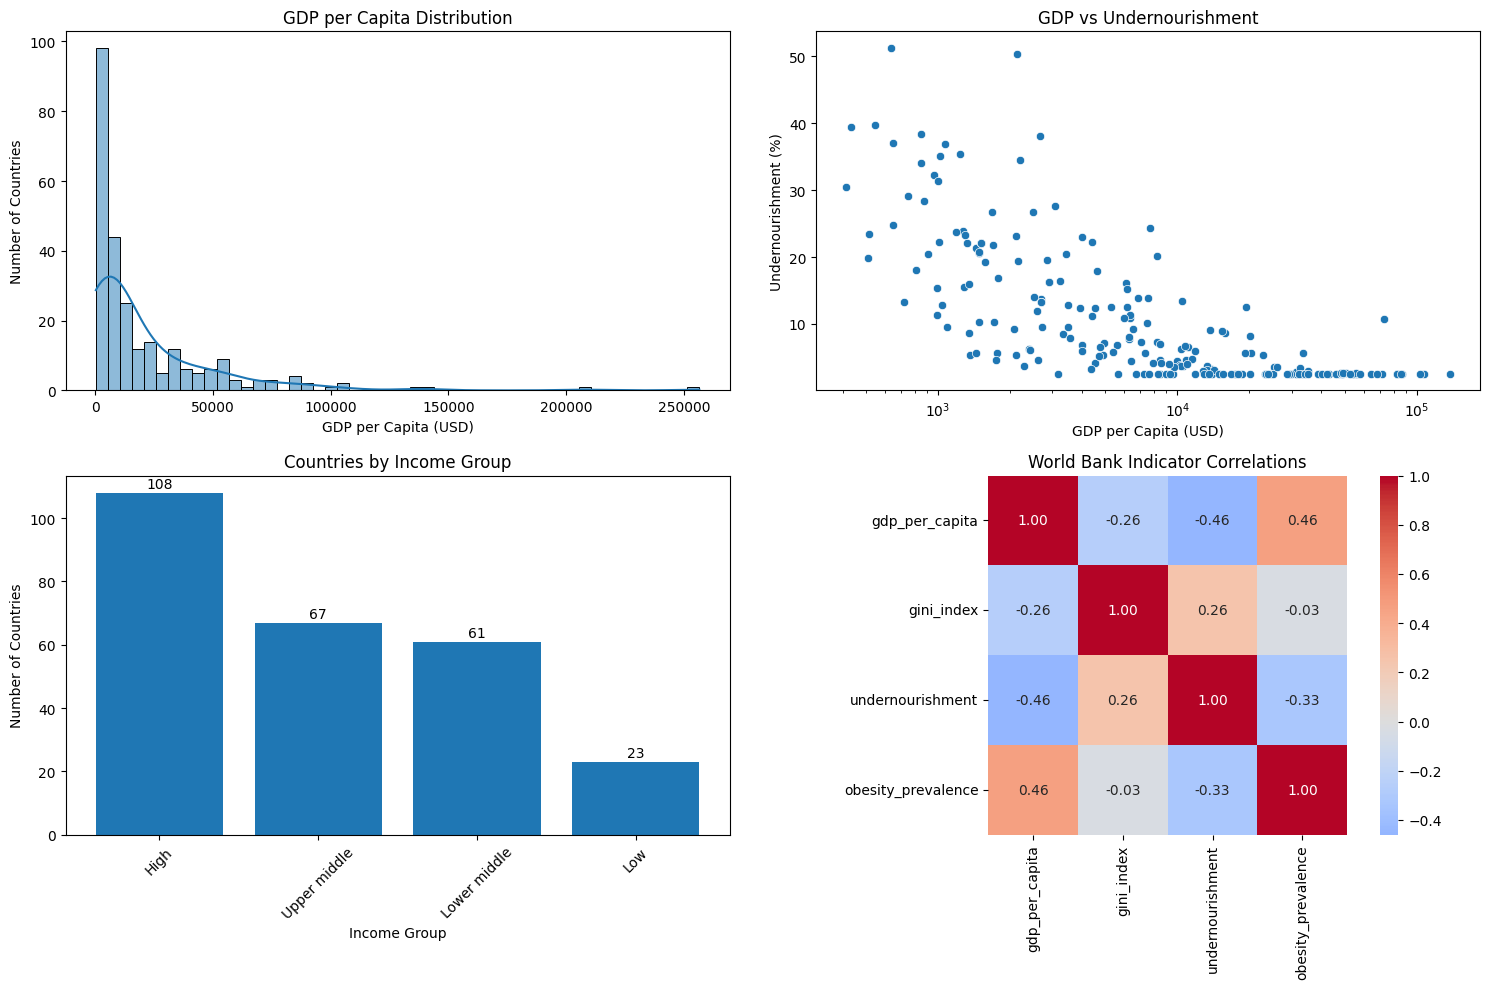


📊 WORLD BANK DATA SUMMARY:
       gdp_per_capita  gini_index  undernourishment  obesity_prevalence
count          259.00      103.00            219.00               71.00
mean         21021.73       35.20             10.65                5.12
std          31224.21        6.63             10.29                3.39
min            153.93       24.10              2.50                0.50
25%           2674.03       30.10              2.50                2.85
50%           8452.37       34.30              5.90                4.30
75%          27496.20       39.00             15.67                7.60
max         256580.52       53.90             51.30               18.20

 INCOME GROUP BREAKDOWN:
   High: 108 countries (40.6%)
   Upper middle: 67 countries (25.2%)
   Lower middle: 61 countries (22.9%)
   Low: 23 countries (8.6%)


In [12]:
# Basic Visualizations of key indicators of WB data

if wb_data is not None:
    print("\nWorld Bank Data Overview:")
    print(f"Countries: {len(wb_data)}")
    print(f"Time period: {wb_data['date'].min().year} to {wb_data['date'].max().year}")
    print("\nSample data:")
    print(wb_data.head())

    # Basic visualization of key indicators with proper axis labels
    plt.figure(figsize=(15, 10))

    # Subplot 1: GDP Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(wb_data['gdp_per_capita'].dropna(), bins=50, kde=True)
    plt.title('GDP per Capita Distribution')
    plt.xlabel('GDP per Capita (USD)')  # ADDED
    plt.ylabel('Number of Countries')   # ADDED

    # Subplot 2: GDP vs Undernourishment
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='gdp_per_capita', y='undernourishment', data=wb_data)
    plt.title('GDP vs Undernourishment')
    plt.xlabel('GDP per Capita (USD)')     # ADDED
    plt.ylabel('Undernourishment (%)')     # ADDED
    plt.xscale('log')

    # Subplot 3: Countries by Income Group
    plt.subplot(2, 2, 3)
    income_counts = wb_data['income_group'].value_counts()
    bars = plt.bar(income_counts.index, income_counts.values)
    plt.title('Countries by Income Group')
    plt.xlabel('Income Group')             # ADDED
    plt.ylabel('Number of Countries')      # ADDED
    plt.xticks(rotation=45)               # ADDED: Better readability

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    # Subplot 4: Correlation Heatmap
    plt.subplot(2, 2, 4)
    correlation_vars = ['gdp_per_capita', 'gini_index', 'undernourishment', 'obesity_prevalence']
    # Filter to available columns
    available_corr_vars = [var for var in correlation_vars if var in wb_data.columns]

    if len(available_corr_vars) >= 2:
        corr_matrix = wb_data[available_corr_vars].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('World Bank Indicator Correlations')
        # Note: Heatmap doesn't need x/y labels as variable names are shown
    else:
        plt.text(0.5, 0.5, 'Insufficient data\nfor correlation matrix',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Correlation Matrix (Insufficient Data)')

    plt.tight_layout()
    plt.show()

    # ADDITIONAL: Summary statistics table
    print("\n📊 WORLD BANK DATA SUMMARY:")
    print("="*50)

    summary_vars = ['gdp_per_capita', 'gini_index', 'undernourishment', 'obesity_prevalence']
    available_summary = [var for var in summary_vars if var in wb_data.columns]

    if available_summary:
        summary_stats = wb_data[available_summary].describe().round(2)
        print(summary_stats)

    # Income group breakdown
    if 'income_group' in wb_data.columns:
        print(f"\n INCOME GROUP BREAKDOWN:")
        income_breakdown = wb_data['income_group'].value_counts()
        for group, count in income_breakdown.items():
            percentage = count / len(wb_data) * 100
            print(f"   {group}: {count} countries ({percentage:.1f}%)")

## **Step 2. Integration Pipeline**

####**Steps for Data Integration**

Aggregate OFF by countries first, then map OFF countries names to World Bank data and merge the datasets


- **Step 1:** Aggregate OFF data by countries
- **Step 2:** Create OFF Country Mapping Strategies
- **Step 3:** OFF Countries Extraction and Mapping
-**Step 4:** Aggregation with Nutritional Data
-**Step 5:** Final Integration


### **Step 2.1: Aggregate OFF Data by Countries**

**Objective:** Transform the product-level OFF dataset into country-level nutritional summaries by calculating mean values and product counts for each country. This aggregation step is essential because World Bank data exists at the country level, requiring us to consolidate individual food products into representative national food profile metrics

In [13]:
# function to aggregate OFF data by country

def efficient_country_aggregation(df_processed):
    """
    country aggregation using vectorized operations
    """
    import time
    start_time = time.time()

    print(" Starting country aggregation...")
    print("This will take some time (5-10 minutes)")
    print(f"Input data: {df_processed.shape}")

    # Step 1: Expand countries using vectorized operations
    print("  Expanding country-product pairs...")

    expanded_rows = []

    # Process in chunks for memory efficiency
    chunk_size = 10000
    total_rows = len(df_processed)

    for i in range(0, total_rows, chunk_size):
        chunk = df_processed.iloc[i:i+chunk_size]

        for idx, row in chunk.iterrows():
            if pd.notna(row.get('countries', '')):
                countries = [c.strip() for c in str(row['countries']).split(',') if c.strip()]

                for country in countries:
                    new_row = row.copy()
                    new_row['country_clean'] = country
                    expanded_rows.append(new_row)

        if (i // chunk_size) % 10 == 0:  # Progress update every 10 chunks
            print(f"    Processed {min(i + chunk_size, total_rows):,}/{total_rows:,} products")

    # Convert to DataFrame
    expanded_df = pd.DataFrame(expanded_rows)
    expand_time = time.time()
    print(f"  ✅ Expansion complete: {len(expanded_df):,} country-product pairs ({expand_time - start_time:.1f}s)")

    # Step 2: Aggregation
    print("  🧮 Aggregating nutritional data by country...")

    # Define nutritional columns to aggregate
    nutrition_cols = [
        'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
        'additives_n', 'ingredients_n', 'fat_energy_ratio', 'protein_energy_ratio'
    ]

    # Filter to available columns
    available_nutrition = [col for col in nutrition_cols if col in expanded_df.columns]
    print(f"    Available nutrition columns: {len(available_nutrition)}")

    # Aggregation
    if available_nutrition:
        country_agg = expanded_df.groupby('country_clean')[available_nutrition].agg([
            'mean',   # Average nutritional values
            'count',  # Number of products
            'std'     # Standard deviation
        ]).round(4)

        # Flatten column names
        country_agg.columns = [f"{col[0]}_{col[1]}" for col in country_agg.columns]
        country_agg = country_agg.reset_index()

        # Add total product count (using the first count column)
        count_cols = [col for col in country_agg.columns if col.endswith('_count')]
        if count_cols:
            country_agg['total_products'] = country_agg[count_cols[0]]
    else:
        print("    ⚠️ No nutrition columns found - creating basic aggregation")
        country_agg = expanded_df.groupby('country_clean').size().reset_index(name='total_products')
        country_agg['country_clean'] = country_agg.index

    # Rename for consistency
    country_agg.rename(columns={'country_clean': 'country_wb'}, inplace=True)

    total_time = time.time() - start_time
    print(f"  ✅ Aggregation complete: {country_agg.shape} ({total_time:.1f}s total)")

    return country_agg

In [14]:
# Performing OFF data aggregation
# Timing the operation, since this might take some time

import time
step1_start = time.time()

# Check prerequisites
if 'processed_data' in globals() and 'df_processed' in processed_data:
    df_processed = processed_data['df_processed']
    print(f"📊 Input data loaded: {df_processed.shape}")

    # Run aggregation
    country_nutrition = efficient_country_aggregation(df_processed)

    print(f"\n📋 AGGREGATION RESULTS:")
    print(f"  Countries found: {len(country_nutrition)}")
    print(f"  Total country-product pairs: {country_nutrition['total_products'].sum():,}")
    print(f"  Average products per country: {country_nutrition['total_products'].mean():.1f}")

    # Show top countries
    print(f"\n🏆 Top 10 countries by product count:")
    if 'total_products' in country_nutrition.columns:
        top_countries = country_nutrition.nlargest(10, 'total_products')
        for _, row in top_countries.iterrows():
            print(f"  {row['country_wb']}: {int(row['total_products']):,} products")

else:
    print("❌ Error: processed_data['df_processed'] not found")
    print("Please run the feature engineering steps first")


📊 Input data loaded: (356027, 45)
 Starting country aggregation...
This will take some time (5-10 minutes)
Input data: (356027, 45)
  Expanding country-product pairs...
    Processed 10,000/356,027 products
    Processed 110,000/356,027 products
    Processed 210,000/356,027 products
    Processed 310,000/356,027 products
  ✅ Expansion complete: 365,466 country-product pairs (266.9s)
  🧮 Aggregating nutritional data by country...
    Available nutrition columns: 12
  ✅ Aggregation complete: (652, 38) (267.0s total)

📋 AGGREGATION RESULTS:
  Countries found: 652
  Total country-product pairs: 365,466
  Average products per country: 560.5

🏆 Top 10 countries by product count:
  US: 170,070 products
  France: 112,145 products
  en:FR: 17,772 products
  Suisse: 13,571 products
  Deutschland: 7,317 products
  España: 4,033 products
  United Kingdom: 3,725 products
  United States: 2,499 products
  en:CH: 2,270 products
  en:BE: 1,884 products


### **Step 2.2: Mapping OFF Countries - Strategies**


**Objective:** Create a comprehensive mapping system to align OFF's informal country names (e.g., "USA", "UK") with World Bank's official country nomenclature (e.g., "United States", "United Kingdom"). This critical step prevents data loss during merging, as the two datasets use different naming conventions that would otherwise result in failed matches.



**Key Differences in Country Names Between 2 Datasets (OFF and WB):**

**Open Food Facts (OFF):**

- Uses common/colloquial names (e.g., "UK", "USA", "Russia")
- Inconsistent formatting and spellings
- May include regions (e.g., "England" instead of "United Kingdom")
- Often uses shorter, informal names
- Multiple countries per product separated by commas
- Has 652 unique countries/variations in the dataset

**World Bank (WB):**

- Uses official country names (e.g., "United Kingdom", "United States", "Russian Federation")
- Standardized format following international conventions
- Includes official designations (e.g., "Korea, Rep." for South Korea)
- Uses specific formats for certain countries (e.g., "Egypt, Arab Rep.", "Iran, Islamic Rep.")

Step 2.2A and 2.2B below create different strategies to comprehensively map OFF countries' names to WB's countries

#### **Step 2.2A. Mapping Strategies**

In [15]:
# =============================================================================
# Helper functions - CREATE AUTOMATED MAPPINGS USING PYCOUNTRY
# =============================================================================

def create_automated_iso_mappings():
    """
    Automatically generates ISO country code mappings (like 'en:FR' → 'France') using the pycountry library,
    including special territories and overseas regions that use non-standard codes.
    """

    iso_mappings = {}

    print("🔄 Creating automated ISO mappings...")

    # Get all countries from pycountry and create mappings
    for country in pycountry.countries:
        iso2 = country.alpha_2  # 2-letter code (FR, DE, etc.)
        name = country.name

        # Map to World Bank standard names
        wb_name = name
        if name == "Czech Republic":
            wb_name = "Czechia"
        elif name == "Slovakia":
            wb_name = "Slovak Republic"
        elif name == "Turkey":
            wb_name = "Turkiye"
        elif name == "Egypt":
            wb_name = "Egypt, Arab Rep."
        elif name == "Iran (Islamic Republic of)":
            wb_name = "Iran, Islamic Rep."
        elif name == "Venezuela (Bolivarian Republic of)":
            wb_name = "Venezuela, RB"
        elif name == "Korea (Republic of)":
            wb_name = "Korea, Rep."
        elif name == "Russian Federation":
            wb_name = "Russian Federation"

        # Create the mappings
        iso_mappings[f"en:{iso2}"] = wb_name  # en:FR format
        iso_mappings[iso2] = wb_name          # FR format

    # Add special territories manually (pycountry doesn't cover these well)
    special_territories = {
        'en:RE': 'France',          # Réunion
        'en:NC': 'France',          # New Caledonia
        'en:MQ': 'France',          # Martinique
        'en:GP': 'France',          # Guadeloupe
        'en:PF': 'France',          # French Polynesia
        'en:GF': 'France',          # French Guiana
        'en:PM': 'France',          # Saint Pierre and Miquelon
        'en:WF': 'France',          # Wallis and Futuna
        'en:YT': 'France',          # Mayotte
        'en:TF': 'France',          # French Southern Territories

        'en:HK': 'Hong Kong SAR, China',
        'en:MO': 'Macao SAR, China',
        'en:TW': 'Taiwan, China',

        'en:PR': 'United States',   # Puerto Rico
        'en:VI': 'United States',   # US Virgin Islands
        'en:GU': 'United States',   # Guam
        'en:AS': 'United States',   # American Samoa

        # Without "en:" prefix versions
        'RE': 'France', 'NC': 'France', 'MQ': 'France', 'GP': 'France', 'PF': 'France',
        'GF': 'France', 'PM': 'France', 'WF': 'France', 'YT': 'France',
    }

    iso_mappings.update(special_territories)
    return iso_mappings


# Helper function
def create_native_language_mappings():
    """
    Creates mappings for country names in their native languages (like 'Österreich' → 'Austria', 'Франция' → 'France')
    to handle multilingual country references in the OFF dataset.
    """

    native_mappings = {
        # German names
        'Österreich': 'Austria', 'Deutschland': 'Germany', 'Frankreich': 'France',
        'Schweiz': 'Switzerland', 'Italien': 'Italy', 'Spanien': 'Spain',
        'Niederlande': 'Netherlands', 'Belgien': 'Belgium', 'Polen': 'Poland',
        'Tschechien': 'Czechia', 'Ungarn': 'Hungary', 'Griechenland': 'Greece',

        # French names
        'Allemagne': 'Germany', 'Angleterre': 'United Kingdom', 'Royaume-Uni': 'United Kingdom',
        'Espagne': 'Spain', 'Italie': 'Italy', 'Pays-Bas': 'Netherlands',
        'Belgique': 'Belgium', 'Suisse': 'Switzerland', 'Autriche': 'Austria',
        'Pologne': 'Poland', 'République tchèque': 'Czechia', 'Hongrie': 'Hungary', 'Grèce': 'Greece',

        # Dutch names
        'Frankrijk': 'France', 'Duitsland': 'Germany', 'Verenigd Koninkrijk': 'United Kingdom',
        'Spanje': 'Spain', 'Italië': 'Italy', 'België': 'Belgium', 'Zwitserland': 'Switzerland',
        'Oostenrijk': 'Austria', 'Polen': 'Poland', 'Tsjechië': 'Czechia', 'Hongarije': 'Hungary',

        # Hungarian names
        'Magyarország': 'Hungary', 'Németország': 'Germany', 'Franciaország': 'France',
        'Olaszország': 'Italy', 'Spanyolország': 'Spain', 'Egyesült Királyság': 'United Kingdom',
        'Ausztria': 'Austria', 'Svájc': 'Switzerland', 'Belgium': 'Belgium', 'Hollandia': 'Netherlands',

        # Polish names
        'Polska': 'Poland', 'Niemcy': 'Germany', 'Francja': 'France', 'Włochy': 'Italy',
        'Hiszpania': 'Spain', 'Wielka Brytania': 'United Kingdom', 'Austria': 'Austria',
        'Szwajcaria': 'Switzerland', 'Belgia': 'Belgium', 'Holandia': 'Netherlands',

        # Greek names
        'Ελλάδα': 'Greece', 'Γερμανία': 'Germany', 'Γαλλία': 'France', 'Ιταλία': 'Italy',
        'Ισπανία': 'Spain', 'Ηνωμένο Βασίλειο': 'United Kingdom',

        # Russian/Cyrillic names
        'Франция': 'France', 'Германия': 'Germany', 'Италия': 'Italy', 'Испания': 'Spain',
        'Великобритания': 'United Kingdom', 'Россия': 'Russian Federation', 'Польша': 'Poland',
        'Чехия': 'Czechia', 'Венгрия': 'Hungary', 'Греция': 'Greece',

        # Portuguese/Spanish names
        'Espanha': 'Spain', 'Alemanha': 'Germany', 'França': 'France', 'Itália': 'Italy',
        'Reino Unido': 'United Kingdom', 'Áustria': 'Austria', 'Suíça': 'Switzerland',
        'Bélgica': 'Belgium', 'Holanda': 'Netherlands', 'Países Baixos': 'Netherlands',

        # Chinese names
        '中華民國': 'Taiwan, China', '中国': 'China', '德国': 'Germany', '法国': 'France',
        '意大利': 'Italy', '西班牙': 'Spain', '英国': 'United Kingdom',

        # Specific territories and regions (full names)
        'Guadeloupe': 'France', 'La Réunion': 'France', 'Martinique': 'France',
        'Polynésie française': 'France', 'Saint-Pierre-et-Miquelon': 'France',
        'Nouvelle-Calédonie': 'France', 'Guyane française': 'France',
        'Wallis-et-Futuna': 'France', 'Mayotte': 'France',

        # Scandinavian names
        'Sverige': 'Sweden', 'Norge': 'Norway', 'Danmark': 'Denmark', 'Suomi': 'Finland',
    }

    return native_mappings

# Create the automated mappings
print("🤖 Creating automated mappings using pycountry library...")
iso_mappings = create_automated_iso_mappings()
native_mappings = create_native_language_mappings()

print(f"✅ ISO mappings created: {len(iso_mappings)} mappings")
print(f"✅ Native language mappings created: {len(native_mappings)} mappings")

🤖 Creating automated mappings using pycountry library...
🔄 Creating automated ISO mappings...
✅ ISO mappings created: 498 mappings
✅ Native language mappings created: 101 mappings


In [16]:
# =============================================================================
# COUNTRY MAPPING DICTIONARY
# =============================================================================

"""
This step creates the mapping dictionary to convert Open Food Facts country names
to World Bank standard names.

Why we need this:
- Open Food Facts: "USA", "UK", "Russia" (informal names)
- World Bank: "United States", "United Kingdom", "Russian Federation" (official names)
- Without mapping, we lose data during merging
"""

# 1. Comprehensive country mapping dictionary
# Maps Open Food Facts country names → World Bank standard names
COUNTRY_MAPPING_ENHANCED = {
    # Major English-speaking countries
    'United States': 'United States', 'USA': 'United States', 'United States of America': 'United States',
    'US': 'United States', 'États-Unis': 'United States', 'Etats-Unis': 'United States',

    'United Kingdom': 'United Kingdom', 'UK': 'United Kingdom', 'Great Britain': 'United Kingdom',
    'England': 'United Kingdom', 'Scotland': 'United Kingdom', 'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom', 'Royaume-Uni': 'United Kingdom',

    # Major European countries
    'France': 'France', 'Francia': 'France', 'République française': 'France',
    'Germany': 'Germany', 'Deutschland': 'Germany', 'Allemagne': 'Germany', 'Federal Republic of Germany': 'Germany',
    'Spain': 'Spain', 'España': 'Spain', 'Espagne': 'Spain',
    'Italy': 'Italy', 'Italia': 'Italy', 'Italie': 'Italy',

    'Netherlands': 'Netherlands', 'The Netherlands': 'Netherlands', 'Holland': 'Netherlands',
    'Pays-Bas': 'Netherlands', 'Nederland': 'Netherlands',

    'Belgium': 'Belgium', 'Belgique': 'Belgium', 'België': 'Belgium',
    'Switzerland': 'Switzerland', 'Suisse': 'Switzerland', 'Schweiz': 'Switzerland', 'Svizzera': 'Switzerland',

    # Major non-European countries
    'Russia': 'Russian Federation', 'Russian Federation': 'Russian Federation', 'Россия': 'Russian Federation',
    'China': 'China', 'People\'s Republic of China': 'China', 'PRC': 'China', '中国': 'China',
    'Japan': 'Japan', '日本': 'Japan', 'Japon': 'Japan',
    'South Korea': 'Korea, Rep.', 'Republic of Korea': 'Korea, Rep.', 'Korea': 'Korea, Rep.', 'Corée du Sud': 'Korea, Rep.',

    'Brazil': 'Brazil', 'Brasil': 'Brazil', 'Brésil': 'Brazil',
    'Mexico': 'Mexico', 'México': 'Mexico', 'Mexique': 'Mexico',
    'Canada': 'Canada', 'Canadá': 'Canada',
    'Australia': 'Australia', 'Australie': 'Australia',
    'India': 'India', 'Inde': 'India', 'Bharat': 'India',

    # Countries with special World Bank naming conventions
    'Czech Republic': 'Czechia', 'Czechia': 'Czechia', 'République tchèque': 'Czechia',
    'Slovakia': 'Slovak Republic', 'Slovak Republic': 'Slovak Republic', 'Slovaquie': 'Slovak Republic',
    'Turkey': 'Turkiye', 'Türkiye': 'Turkiye', 'Turquie': 'Turkiye',

    # Middle East and Africa with World Bank formats
    'Egypt': 'Egypt, Arab Rep.', 'Iran': 'Iran, Islamic Rep.', 'Venezuela': 'Venezuela, RB',
    'Syria': 'Syrian Arab Republic', 'Yemen': 'Yemen, Rep.', 'Congo': 'Congo, Rep.',
    'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'DRC': 'Congo, Dem. Rep.',
    'Ivory Coast': 'Cote d\'Ivoire', 'Côte d\'Ivoire': 'Cote d\'Ivoire',
    'The Gambia': 'Gambia, The', 'Gambia': 'Gambia, The',
    'The Bahamas': 'Bahamas, The', 'Bahamas': 'Bahamas, The',
    'Cape Verde': 'Cabo Verde', 'Cabo Verde': 'Cabo Verde',
    'Laos': 'Lao PDR', 'Myanmar': 'Myanmar', 'Burma': 'Myanmar',
    'Macedonia': 'North Macedonia', 'North Macedonia': 'North Macedonia',
    'Bosnia': 'Bosnia and Herzegovina', 'Bosnia and Herzegovina': 'Bosnia and Herzegovina',

    # Special territories and regions
    'Hong Kong': 'Hong Kong SAR, China', 'Macao': 'Macao SAR, China', 'Macau': 'Macao SAR, China',
    'Palestine': 'West Bank and Gaza', 'Palestinian Territories': 'West Bank and Gaza',

    # Small island nations
    'Saint Lucia': 'St. Lucia', 'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'Saint Kitts and Nevis': 'St. Kitts and Nevis', 'São Tomé and Príncipe': 'Sao Tome and Principe',

    # Additional countries
    'South Africa': 'South Africa', 'New Zealand': 'New Zealand', 'Norway': 'Norway', 'Sweden': 'Sweden',
    'Denmark': 'Denmark', 'Finland': 'Finland', 'Austria': 'Austria', 'Portugal': 'Portugal',
    'Greece': 'Greece', 'Poland': 'Poland', 'Hungary': 'Hungary', 'Romania': 'Romania',
    'Bulgaria': 'Bulgaria', 'Croatia': 'Croatia', 'Slovenia': 'Slovenia', 'Lithuania': 'Lithuania',
    'Latvia': 'Latvia', 'Estonia': 'Estonia', 'Ireland': 'Ireland', 'Iceland': 'Iceland',
    'Luxembourg': 'Luxembourg', 'Malta': 'Malta', 'Cyprus': 'Cyprus',

}

# 2. Add automated iso mapping and native mapping to the dictionary (from previous step)
iso_mappings = create_automated_iso_mappings()      # Creates ~500 ISO mappings
native_mappings = create_native_language_mappings() # Creates ~100 native name mappings

COUNTRY_MAPPING_ENHANCED.update(iso_mappings)
COUNTRY_MAPPING_ENHANCED.update(native_mappings)

print("🗺️ COUNTRY MAPPING SYSTEM LOADED")
print(f"📚 Mapping dictionary contains {len(COUNTRY_MAPPING_ENHANCED)} country variations")
print("🎯 Covers major countries in multiple languages and naming conventions")

🔄 Creating automated ISO mappings...
🗺️ COUNTRY MAPPING SYSTEM LOADED
📚 Mapping dictionary contains 713 country variations
🎯 Covers major countries in multiple languages and naming conventions


In [17]:
#Helper function for n-gram matching strategy

# =============================================================================
# N-GRAM FUNCTIONS
# =============================================================================

def ngram_similarity(s1, s2, n=3):
    """
    n-gram matching

    Args:
        s1, s2: strings to compare
        n: size of n-grams (3 = trigrams, 2 = bigrams)

    Returns:
        float: similarity score between 0 and 1
    """
    # Convert to lowercase and remove spaces for comparison
    s1 = s1.lower().replace(' ', '')
    s2 = s2.lower().replace(' ', '')

    # Handle edge cases
    if not s1 or not s2:
        return 0.0
    if s1 == s2:
        return 1.0

    # Create n-grams (chunks of n characters)
    def get_ngrams(text, n):
        if len(text) < n:
            return [text]  # If text is shorter than n, return the whole text

        ngrams = []
        for i in range(len(text) - n + 1):
            ngrams.append(text[i:i+n])
        return ngrams

    # Get n-grams for both strings
    ngrams1 = get_ngrams(s1, n)
    ngrams2 = get_ngrams(s2, n)

    # Convert to sets to find common n-grams
    set1 = set(ngrams1)
    set2 = set(ngrams2)

    # Calculate similarity: intersection / union
    intersection = len(set1.intersection(set2))  # Common n-grams
    union = len(set1.union(set2))                # All unique n-grams

    if union == 0:
        return 0.0

    return intersection / union


#### **Step 2.2B. Mapping Function**

In [18]:
# =============================================================================
# STEP 2.2B: COUNTRY MAPPING FUNCTION
# =============================================================================

"""
This step creates the function to map country names using multiple strategies.

The function tries several approaches in order of reliability:
1. Direct lookup in our mapping dictionary (handles abbreviations like "USA" → "United States") (including ISO codes and native language naming))
2. Case-insensitive lookup in mapping dictionary (handles capitalization differences)
3. Exact match with World Bank country list (for countries already in standard format)
4. Case-insensitive match with World Bank list (handles capitalization in standard names)
5. High-confidence fuzzy string matching (≥85% similarity for clear typos)
6. N-gram matching (compares character chunks to catch spelling variations like "Germeny" → "Germany")
7. Lower-confidence fuzzy matching (≥70% similarity as final fallback for borderline cases)

Each strategy only runs if previous ones fail, prioritizing speed and accuracy while maximizing coverage.
"""


def map_country_to_wb(country_name, wb_countries_list):
    """
    Country mapping with various strategies for capturing all variations of countries' names

    """

    # Handle missing/null values
    if pd.isna(country_name):
        return None

    country_clean = str(country_name).strip()

    # Strategy 1: Direct mapping from dictionary (including ISO codes and native language naming)
    if country_clean in COUNTRY_MAPPING_ENHANCED:
        return COUNTRY_MAPPING_ENHANCED[country_clean]

    # Strategy 2: Case-insensitive mapping from dictionary
    for key, value in COUNTRY_MAPPING_ENHANCED.items():
        if key.lower() == country_clean.lower():
            return value

    # Strategy 3: Exact match in World Bank list
    if country_clean in wb_countries_list:
        return country_clean

    # Strategy 4: Case-insensitive match in World Bank list
    for wb_country in wb_countries_list:
        if wb_country.lower() == country_clean.lower():
            return wb_country

    # Strategy 5: Fuzzy matching
    matches = process.extract(country_clean, wb_countries_list, scorer=fuzz.ratio, limit=1)
    if matches and matches[0][1] >= 85:
        return matches[0][0]

    # Strategy 6: SIMPLE N-GRAM MATCHING
    best_match = None
    best_score = 0

    for wb_country in wb_countries_list:
        # Try trigrams (3-character chunks)
        similarity = ngram_similarity(country_clean, wb_country, n=3)

        if similarity > best_score:
            best_score = similarity
            best_match = wb_country

    # If we found a decent match (50% similarity), use it
    if best_score >= 0.5:
        return best_match

    # Strategy 7: Lower confidence fuzzy matching (same as original)
    if matches and matches[0][1] >= 70:
        return matches[0][0]

    # No good match found
    return None


# Test the mapping function if World Bank data is available
if 'wb_data' in globals():
    wb_countries_list = wb_data['country'].tolist()

    # Test with common variations we expect to see
    test_countries = ['USA', 'UK', 'Deutschland', 'España', 'Brasil', 'South Korea', 'Russia']

    print("\n Testing Country Mapping Function:")
    print("-" * 50)
    for country in test_countries:
        mapped = map_country_to_wb(country, wb_countries_list)
        status = "✅" if mapped else "❌"
        print(f"  {status} '{country}' → '{mapped}'")

    print(f"\n🌍 World Bank has {len(wb_countries_list)} countries available for matching")
else:
    print("⚠️  World Bank data not yet loaded - will test mapping in next steps")


 Testing Country Mapping Function:
--------------------------------------------------
  ✅ 'USA' → 'United States'
  ✅ 'UK' → 'United Kingdom'
  ✅ 'Deutschland' → 'Germany'
  ✅ 'España' → 'Spain'
  ✅ 'Brasil' → 'Brazil'
  ✅ 'South Korea' → 'Korea, Rep.'
  ✅ 'Russia' → 'Russian Federation'

🌍 World Bank has 266 countries available for matching


### **Step 2.3: Country Extraction and Mapping**

**Objective:** Apply the mapping dictionary to extract and standardize all country references from the OFF dataset, handling multi-country products and resolving naming inconsistencies. This step ensures maximum data retention while maintaining geographic accuracy for subsequent analysis.

In [19]:
# =============================================================================
# STEP 2.3: COUNTRY EXTRACTION AND MAPPING
# =============================================================================

"""
This step extract and map OFF countries to WB countries.

1. Extract unique countries from all products FIRST
2. Map the unique country names ONCE
"""

if 'df_processed' not in globals() or 'wb_data' not in globals():
    print("⚠️  Please run previous steps to load df_processed and wb_data first")
else:
    print(" Starting country extraction and mapping...")

    # STEP 1: Extract all unique countries
    print("\n📊 STEP 1: Extracting unique countries from dataset...")

    # Get all country strings and split by comma efficiently
    all_countries = []
    country_strings = df_processed['countries'].dropna()

    print(f"Processing {len(country_strings):,} products with country data...")

    # Use vectorized string operations
    for countries_str in country_strings:
        countries = [c.strip() for c in str(countries_str).split(',') if c.strip()]
        all_countries.extend(countries)

    # Count unique countries
    from collections import Counter
    country_counts = Counter(all_countries)
    unique_countries = list(country_counts.keys())

    print(f"✅ Found {len(unique_countries)} unique countries")
    print(f" Total country mentions: {sum(country_counts.values()):,}")

    # Show top countries
    print(f"\n🏆 Top 15 countries by product mentions:")
    for country, count in country_counts.most_common(15):
        print(f"  {country}: {count:,} products")

    # STEP 2: Map unique countries to World Bank names
    print(f"\n  STEP 2: Mapping {len(unique_countries)} unique countries to World Bank names...")

    wb_countries_list = wb_data['country'].tolist()

    # Create mapping dictionary for ALL unique countries at once
    country_mapping = {}
    mapping_stats = {'mapped': 0, 'unmapped': 0}

    for country in unique_countries:
        wb_name = map_country_to_wb(country, wb_countries_list)
        if wb_name:
            country_mapping[country] = wb_name
            mapping_stats['mapped'] += 1
        else:
            mapping_stats['unmapped'] += 1

    # Show mapping results
    print(f"📊 Mapping Results:")
    print(f"  Successfully mapped: {mapping_stats['mapped']}")
    print(f"  Unmapped countries: {mapping_stats['unmapped']}")
    print(f"  Success rate: {mapping_stats['mapped']/len(unique_countries)*100:.1f}%")

    # Show sample mappings
    print(f"\n Sample Mappings:")
    for i, (original, mapped) in enumerate(list(country_mapping.items())[:10]):
        print(f"  '{original}' → '{mapped}'")

    print(f"\n✅ Country mapping complete!")


 Starting country extraction and mapping...

📊 STEP 1: Extracting unique countries from dataset...
Processing 355,752 products with country data...
✅ Found 652 unique countries
 Total country mentions: 365,466

🏆 Top 15 countries by product mentions:
  US: 170,070 products
  France: 112,145 products
  en:FR: 17,772 products
  Suisse: 13,571 products
  Deutschland: 7,317 products
  España: 4,033 products
  United Kingdom: 3,725 products
  United States: 2,499 products
  en:CH: 2,270 products
  en:BE: 1,884 products
  en:GB: 1,684 products
  Australia: 1,550 products
  Belgique: 1,516 products
  Россия: 1,416 products
  en:ES: 1,142 products

  STEP 2: Mapping 652 unique countries to World Bank names...
📊 Mapping Results:
  Successfully mapped: 497
  Unmapped countries: 155
  Success rate: 76.2%

 Sample Mappings:
  'en:FR' → 'France'
  'US' → 'United States'
  'France' → 'France'
  'en:GB' → 'United Kingdom'
  'États-Unis' → 'United States'
  'Canada' → 'Canada'
  'United Kingdom' → 'Un

### **Step 2.4: Nutritional Aggregation**

**Objective:** Generate robust country-level nutritional profiles by aggregating 18+ core features (macronutrients, additives, health indicators) and incorporating Nutri-Score quality metrics. This creates reliable country food signatures that can be meaningfully compared against socioeconomic indicators.

In [20]:
# =============================================================================
# STEP 2.4: NUTRITIONAL AGGREGATION USING PRE-BUILT MAPPING
# =============================================================================

"""
Now that we have the country mapping, we can aggregate nutritional data.

This approach:
1. Uses the pre-built country mapping from Step 2.3
2. Creates the dataset that will be merged with World Bank data
3. Calculates country-level statistics (mean nutrition values, Nutri-Scores, etc.)
"""

if 'country_mapping' not in globals():
    print("  Please run Step 2.3 first to create country_mapping")
else:
    print("🧮 Starting nutritional aggregation...")
    print("Using pre-built country mapping ")

    # Define the 18 core nutritional features
    core_nutritional_features = [
        # Basic macronutrients (9 features)
        'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',

        # Product characteristics (2 features)
        'additives_n', 'ingredients_from_palm_oil_n',

        # Engineered ratios (3 features)
        'fat_energy_ratio', 'protein_energy_ratio', 'sugar_carb_ratio',

        # Health indicators (4 features)
        'high_fiber', 'high_protein', 'low_salt', 'low_sugar'
    ]

    # Check available features
    available_features = [col for col in core_nutritional_features if col in df_processed.columns]
    print(f"📊 Available features: {len(available_features)}/18")

    # Approach: Process data in chunks and use vectorized operations
    print(f"\n🔄 Processing nutritional data ...")

    # Create a function to map countries for each row
    def map_countries_vectorized(countries_str):
        """Map countries in a string to World Bank names, return first valid mapping"""
        if pd.isna(countries_str):
            return None

        countries = [c.strip() for c in str(countries_str).split(',')]
        for country in countries:
            if country in country_mapping:
                return country_mapping[country]
        return None

    # Apply mapping using vectorized operations
    print("  Mapping countries for all products...")
    df_processed['country_wb'] = df_processed['countries'].apply(map_countries_vectorized)

    # Filter to products with successful mapping
    mapped_data = df_processed[df_processed['country_wb'].notna()].copy()
    print(f"  Products with mapped countries: {len(mapped_data):,}")

    # Aggregation using pandas groupby
    print(f"  Aggregating {len(available_features)} features by country...")

    country_nutrition = mapped_data.groupby('country_wb')[available_features].agg([
        'mean',  # Average values
        'count'  # Product counts
    ]).round(4)

    # Flatten column names
    country_nutrition.columns = [f"{col[0]}_{col[1]}" for col in country_nutrition.columns]
    country_nutrition = country_nutrition.reset_index()

    # Add total product count
    count_columns = [col for col in country_nutrition.columns if col.endswith('_count')]
    if count_columns:
        main_count_col = next((col for col in count_columns if 'energy' in col), count_columns[0])
        country_nutrition['total_products'] = country_nutrition[main_count_col]

    print(f"✅ Nutritional aggregation complete!")
    print(f"📁 Shape: {country_nutrition.shape}")
    print(f"🌍 Countries: {len(country_nutrition)}")

    # NUTRI-SCORE AGGREGATION
    print(f"\n Processing Nutri-Score data ..")

    # Filter to products with Nutri-Scores and mapped countries
    nutri_data = mapped_data[mapped_data['nutrition_grade_encoded'].notna()].copy()

    if len(nutri_data) > 0:
        print(f" Found {len(nutri_data):,} products with Nutri-Scores")

        # Nutri-Score aggregation
        nutri_agg = nutri_data.groupby('country_wb')['nutrition_grade_encoded'].agg([
            'count',  # Total products
            'mean',   # Average score
            'std',    # Standard deviation
            lambda x: (x == 0).sum(),  # Count of Grade A
            lambda x: (x == 4).sum(),  # Count of Grade E
            lambda x: ((x == 0) | (x == 1)).sum()  # Count of Grades A+B
        ]).round(3)

        # Rename columns
        nutri_agg.columns = ['nutri_total_products', 'nutri_avg_score', 'nutri_score_std',
                            'count_a', 'count_e', 'count_healthy']

        # Calculate percentages
        nutri_agg['nutri_pct_a'] = (nutri_agg['count_a'] / nutri_agg['nutri_total_products'] * 100).round(2)
        nutri_agg['nutri_pct_e'] = (nutri_agg['count_e'] / nutri_agg['nutri_total_products'] * 100).round(2)
        nutri_agg['nutri_healthy_ratio'] = (nutri_agg['count_healthy'] / nutri_agg['nutri_total_products'] * 100).round(2)

        # Custom quality index
        nutri_agg['nutri_quality_index'] = ((nutri_agg['nutri_pct_a'] * 2 + (100 - nutri_agg['nutri_pct_e'])) / 3).round(2)

        # Clean up and reset index
        nutri_features = nutri_agg.drop(['count_a', 'count_e', 'count_healthy'], axis=1).reset_index()

        print(f"✅ Nutri-Score features created: {nutri_features.shape}")
    else:
        print("❌ No Nutri-Score data found")
        nutri_features = pd.DataFrame({'country_wb': []})

    # Show preview
    print(f"\n📋 Preview - Top 10 Countries:")
    if 'total_products' in country_nutrition.columns:
        top_countries = country_nutrition.nlargest(10, 'total_products')
        display_cols = ['country_wb', 'total_products', 'energy_100g_mean', 'nutri_avg_score'] if 'nutri_avg_score' in top_countries.columns else ['country_wb', 'total_products', 'energy_100g_mean']
        available_cols = [col for col in display_cols if col in top_countries.columns]
        print(top_countries[available_cols].to_string(index=False))


🧮 Starting nutritional aggregation...
Using pre-built country mapping 
📊 Available features: 18/18

🔄 Processing nutritional data ...
  Mapping countries for all products...
  Products with mapped countries: 355,436
  Aggregating 18 features by country...
✅ Nutritional aggregation complete!
📁 Shape: (162, 38)
🌍 Countries: 162

 Processing Nutri-Score data ..
 Found 254,712 products with Nutri-Scores
✅ Nutri-Score features created: (92, 8)

📋 Preview - Top 10 Countries:
        country_wb  total_products  energy_100g_mean
     United States          173279         1132.6179
            France          127950         1107.0504
       Switzerland           15234         1120.8917
           Germany            8871         1145.5019
             Spain            5638         1055.7976
    United Kingdom            5332         1091.5099
           Belgium            3839         1117.9290
         Australia            2306         1064.7372
Russian Federation            1583         1055.0

### **Step 2.5: Final Data Integration**

**Objective:** Execute the final merge between aggregated food data and World Bank indicators, creating a unified dataset that combines economic development metrics (GDP, inequality), health outcomes (obesity, undernourishment), and food quality measures.

In [21]:
# =============================================================================
# STEP 2.5: DATA INTEGRATION
# =============================================================================

def streamlined_integration(wb_data, country_nutrition, nutri_features):
    """
    integration of World Bank + OFF data
    """
    print("="*60)

    # Define core features
    wb_core_cols = ['country', 'gdp_per_capita', 'population', 'undernourishment',
                    'obesity_prevalence', 'gini_index', 'income_group']

    nutrition_core_cols = ['country_wb', 'total_products', 'energy_100g_mean',
                          'proteins_100g_mean', 'fat_100g_mean', 'salt_100g_mean',
                          'additives_n_mean', 'fat_energy_ratio_mean']

    nutri_core_cols = ['country_wb', 'nutri_avg_score', 'nutri_pct_a',
                      'nutri_quality_index', 'nutri_total_products']

    # Filter to available columns
    wb_available = [col for col in wb_core_cols if col in wb_data.columns]
    nutrition_available = [col for col in nutrition_core_cols if col in country_nutrition.columns]
    nutri_available = [col for col in nutri_core_cols if col in nutri_features.columns] if len(nutri_features) > 0 else ['country_wb']

    print(f"Features selected: WB({len(wb_available)}), Nutrition({len(nutrition_available)}), Nutri-Score({len(nutri_available)})")

    # Single chain merge
    wb_base = wb_data[wb_available].rename(columns={'country': 'country_wb'})
    nutrition_subset = country_nutrition[nutrition_available] if len(nutrition_available) > 1 else pd.DataFrame({'country_wb': []})
    nutri_subset = nutri_features[nutri_available] if len(nutri_available) > 1 else pd.DataFrame({'country_wb': []})

    # Chain operations
    final_dataset = (wb_base
                    .merge(nutrition_subset, on='country_wb', how='left')
                    .merge(nutri_subset, on='country_wb', how='left'))

    # Single fillna operation
    numeric_cols = final_dataset.select_dtypes(include=[np.number]).columns
    final_dataset[numeric_cols] = final_dataset[numeric_cols].fillna(0)

    # Handle categorical income_group
    if 'income_group' in final_dataset.columns:
        # Convert categorical to string to avoid category restrictions
        final_dataset['income_group'] = final_dataset['income_group'].astype(str)
        final_dataset['income_group'] = final_dataset['income_group'].replace('nan', 'Unknown')
        final_dataset['income_group'] = final_dataset['income_group'].fillna('Unknown')

    # Essential flags
    final_dataset['has_nutritional_data'] = final_dataset.get('total_products', pd.Series(0)) > 0
    final_dataset['sufficient_data'] = final_dataset.get('total_products', pd.Series(0)) >= 20

    print(f"✅ Integration complete: {final_dataset.shape}")
    print(f"Countries with data: {final_dataset['has_nutritional_data'].sum()}")

    return final_dataset


In [22]:
final_dataset = streamlined_integration(wb_data, country_nutrition, nutri_features)

Features selected: WB(7), Nutrition(8), Nutri-Score(5)
✅ Integration complete: (266, 20)
Countries with data: 148


### **Step 2.6. Exploratory Data Analysis on the Merged Dataset**

**Objective:** Conduct comprehensive EDA to identify patterns, correlations, and insights in the integrated dataset, using data quality filters and weighted analyses to account for varying sample sizes across countries. This step validates hypotheses about economic development and food quality relationships.

In [23]:
# =============================================================================
#  Data Quality Assessment and Filtering Setup
# =============================================================================

print("🚀 STEP 2.6A: Data Quality Assessment and Filtering Setup")
print("="*70)

if 'final_dataset' not in globals():
    print("⚠️  ERROR: Please run Step 2.5 first to create final_dataset")
else:
    print("✅ final_dataset found - starting EDA")
    print("🎯 This analysis addresses data skewness and focuses on statistically meaningful patterns")

    # Analyze data distribution to set thresholds
    print(f"\n📊 DATA QUALITY ASSESSMENT")
    print("-" * 60)

    if 'total_products' in final_dataset.columns:
        # Get product count statistics
        product_stats = final_dataset[final_dataset['total_products'] > 0]['total_products'].describe()

        print("Product count distribution across countries:")
        print(f"  Countries with data: {(final_dataset['total_products'] > 0).sum()}")
        print(f"  Mean products: {product_stats['mean']:.1f}")
        print(f"  Median products: {product_stats['50%']:.1f}")
        print(f"  75th percentile: {product_stats['75%']:.1f}")
        print(f"  90th percentile: {final_dataset[final_dataset['total_products'] > 0]['total_products'].quantile(0.9):.1f}")
        print(f"  Maximum: {product_stats['max']:.0f}")

        # Set thresholds based on data distribution
        min_products_basic = 5    # Basic analysis threshold
        min_products_robust = 20  # Robust statistical analysis threshold
        min_products_detailed = 50 # Detailed country comparisons

        print(f"\n🎯 Analysis Thresholds:")
        print(f"  Basic analysis: ≥{min_products_basic} products")
        print(f"  Robust analysis: ≥{min_products_robust} products")
        print(f"  Detailed analysis: ≥{min_products_detailed} products")

        # Create filtered datasets for different analysis levels
        print(f"\n🔍 Filtered datasets...")

        # Basic dataset (≥5 products + has nutritional data)
        basic_data = final_dataset[
            (final_dataset['total_products'] >= min_products_basic) &
            (final_dataset['has_nutritional_data'] == True)
        ].copy()

        # Robust dataset (≥20 products + has nutritional data)
        robust_data = final_dataset[
            (final_dataset['total_products'] >= min_products_robust) &
            (final_dataset['has_nutritional_data'] == True)
        ].copy()

        # Detailed dataset (≥50 products + has nutritional data)
        detailed_data = final_dataset[
            (final_dataset['total_products'] >= min_products_detailed) &
            (final_dataset['has_nutritional_data'] == True)
        ].copy()

        print(f"📊 Filtered Analysis Groups Created:")
        print(f"  All countries: {len(final_dataset)}")
        print(f"  Basic analysis (≥{min_products_basic} products): {len(basic_data)} countries")
        print(f"  Robust analysis (≥{min_products_robust} products): {len(robust_data)} countries")
        print(f"  Detailed analysis (≥{min_products_detailed} products): {len(detailed_data)} countries")

        # Show countries that will be excluded from main analysis
        excluded_countries = final_dataset[
            (final_dataset['has_nutritional_data'] == True) &
            (final_dataset['total_products'] < min_products_basic)
        ]['country_wb'].tolist()

        if len(excluded_countries) > 0:
            print(f"\n⚠️  Countries with insufficient data (excluded from main analysis):")
            print(f"   Count: {len(excluded_countries)} countries")
            excluded_sample = excluded_countries[:10]
            print(f"   Sample: {', '.join(excluded_sample)}")
            if len(excluded_countries) > 10:
                print(f"   ... and {len(excluded_countries) - 10} others")

        # Show top countries by sample size
        if len(basic_data) > 0:
            print(f"\n🏆 Top 10 countries by data completeness:")
            top_data_countries = basic_data.nlargest(10, 'total_products')
            for _, row in top_data_countries.iterrows():
                products = int(row['total_products'])
                gdp = row.get('gdp_per_capita', 0)
                gdp_str = f", GDP: ${gdp:,.0f}" if gdp > 0 else ""
                print(f"   {row['country_wb']}: {products:,} products{gdp_str}")

    else:
        print("❌ total_products column not found - cannot assess data quality")



🚀 STEP 2.6A: Data Quality Assessment and Filtering Setup
✅ final_dataset found - starting EDA
🎯 This analysis addresses data skewness and focuses on statistically meaningful patterns

📊 DATA QUALITY ASSESSMENT
------------------------------------------------------------
Product count distribution across countries:
  Countries with data: 148
  Mean products: 2400.0
  Median products: 15.0
  75th percentile: 85.5
  90th percentile: 376.4
  Maximum: 173279

🎯 Analysis Thresholds:
  Basic analysis: ≥5 products
  Robust analysis: ≥20 products
  Detailed analysis: ≥50 products

🔍 Filtered datasets...
📊 Filtered Analysis Groups Created:
  All countries: 266
  Basic analysis (≥5 products): 104 countries
  Robust analysis (≥20 products): 65 countries
  Detailed analysis (≥50 products): 44 countries

⚠️  Countries with insufficient data (excluded from main analysis):
   Count: 44 countries
   Sample: Afghanistan, Angola, Barbados, Brunei Darussalam, Burundi, Central African Republic, Chad, Congo

🔗 STEP 2.6B: Correlation Analysis
📊 Analyzing correlations for 65 countries with robust data
Focused variables for correlation analysis: 8
  ✅ gdp_per_capita
  ✅ gini_index
  ✅ undernourishment
  ✅ obesity_prevalence
  ✅ energy_100g_mean
  ✅ additives_n_mean
  ✅ nutri_avg_score
  ✅ nutri_quality_index

🧮 Calculating focused correlation matrix...


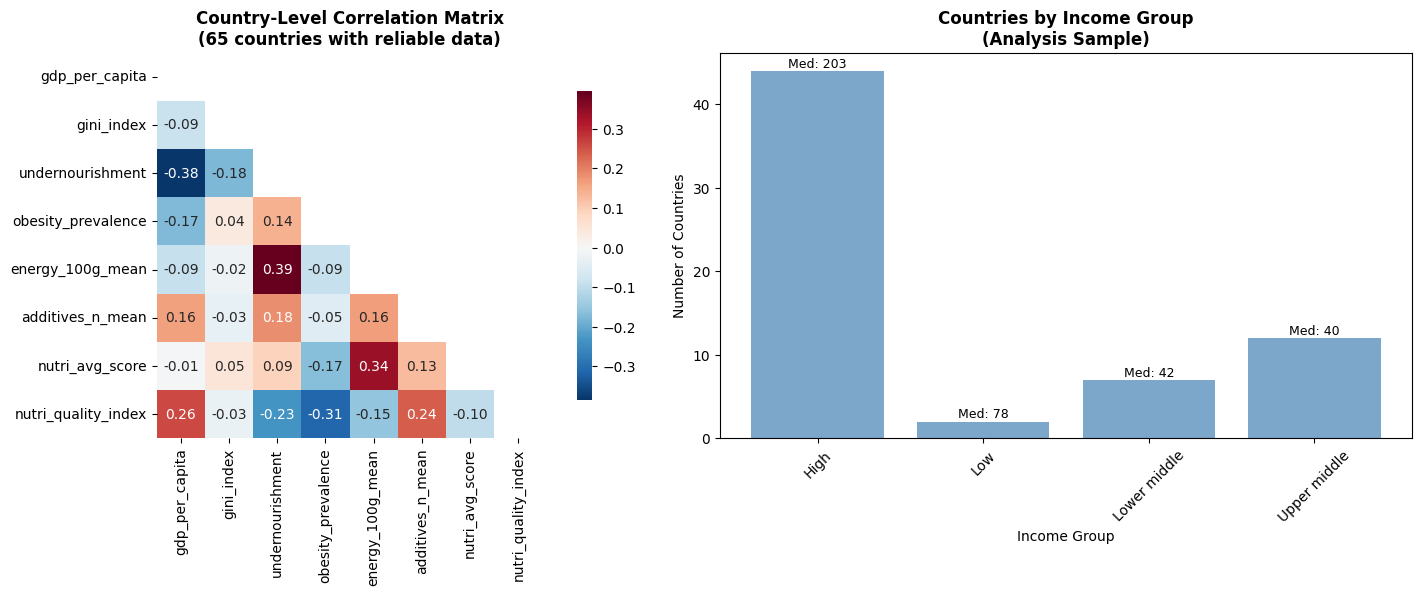


🔍 SIGNIFICANT CORRELATIONS (|r| > 0.5):
  No correlations with |r| > 0.5 found


In [24]:
# =============================================================================
# Robust Correlation Analysis
# =============================================================================

'''
Robust analysis (≥20 products)
'''

print("🔗 STEP 2.6B: Correlation Analysis")
print("="*60)

if 'robust_data' not in globals() or len(robust_data) < 10:
    print("⚠️  Need at least 10 countries with robust data for meaningful correlations")
    if 'robust_data' in globals():
        print(f"   Current robust_data size: {len(robust_data)} countries")
else:
    print(f"📊 Analyzing correlations for {len(robust_data)} countries with robust data")

    # Select 6-8 key variables focusing on big picture patterns
    correlation_vars = []

    # Economic indicators (core development metrics)
    econ_vars = ['gdp_per_capita', 'gini_index']
    correlation_vars.extend([var for var in econ_vars if var in robust_data.columns])

    # Health indicators (population outcomes)
    health_vars = ['undernourishment', 'obesity_prevalence']
    correlation_vars.extend([var for var in health_vars if var in robust_data.columns])

    # Food system indicators (overall food environment quality)
    food_system_vars = ['energy_100g_mean', 'additives_n_mean']
    correlation_vars.extend([var for var in food_system_vars if var in robust_data.columns])

    # Food quality indicators (comprehensive measures)
    quality_vars = ['nutri_avg_score', 'nutri_quality_index']
    correlation_vars.extend([var for var in quality_vars if var in robust_data.columns])

    print(f"Focused variables for correlation analysis: {len(correlation_vars)}")
    for var in correlation_vars:
        print(f"  ✅ {var}")

    if len(correlation_vars) >= 6:
        # Calculate correlations
        print(f"\n🧮 Calculating focused correlation matrix...")
        corr_matrix = robust_data[correlation_vars].corr()

        # Create correlation visualization
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Correlation heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.2f', ax=ax1, cbar_kws={"shrink": .8})
        ax1.set_title(f'Country-Level Correlation Matrix\n({len(robust_data)} countries with reliable data)',
                     fontweight='bold', fontsize=12)

        # Income group sample sizes
        if 'income_group' in robust_data.columns:
            sample_sizes = robust_data.groupby('income_group')['total_products'].agg(['count', 'mean', 'median'])
            sample_sizes = sample_sizes.reset_index()

            x_pos = np.arange(len(sample_sizes))
            bars = ax2.bar(x_pos, sample_sizes['count'], alpha=0.7, color='steelblue')
            ax2.set_xlabel('Income Group')
            ax2.set_ylabel('Number of Countries')
            ax2.set_title('Countries by Income Group\n(Analysis Sample)', fontweight='bold')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(sample_sizes['income_group'], rotation=45)

            # Add median product counts as text
            for i, (_, row) in enumerate(sample_sizes.iterrows()):
                ax2.text(i, row['count'] + 0.1, f"Med: {row['median']:.0f}",
                        ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Report significant correlations
        print(f"\n🔍 SIGNIFICANT CORRELATIONS (|r| > 0.5):")
        strong_corrs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if not pd.isna(corr_val) and abs(corr_val) > 0.5:
                    var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    strong_corrs.append((var1, var2, corr_val))

        if strong_corrs:
            for var1, var2, corr_val in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
                direction = "positive" if corr_val > 0 else "negative"
                print(f"  {var1} ↔ {var2}: {corr_val:.3f} ({direction})")
        else:
            print("  No correlations with |r| > 0.5 found")

🏆 STEP 2.6C: Weighted Country Performance Analysis
📊 Analyzing top performers from 44 countries with comprehensive data
✅ Reliability weighting applied (median products: 242)


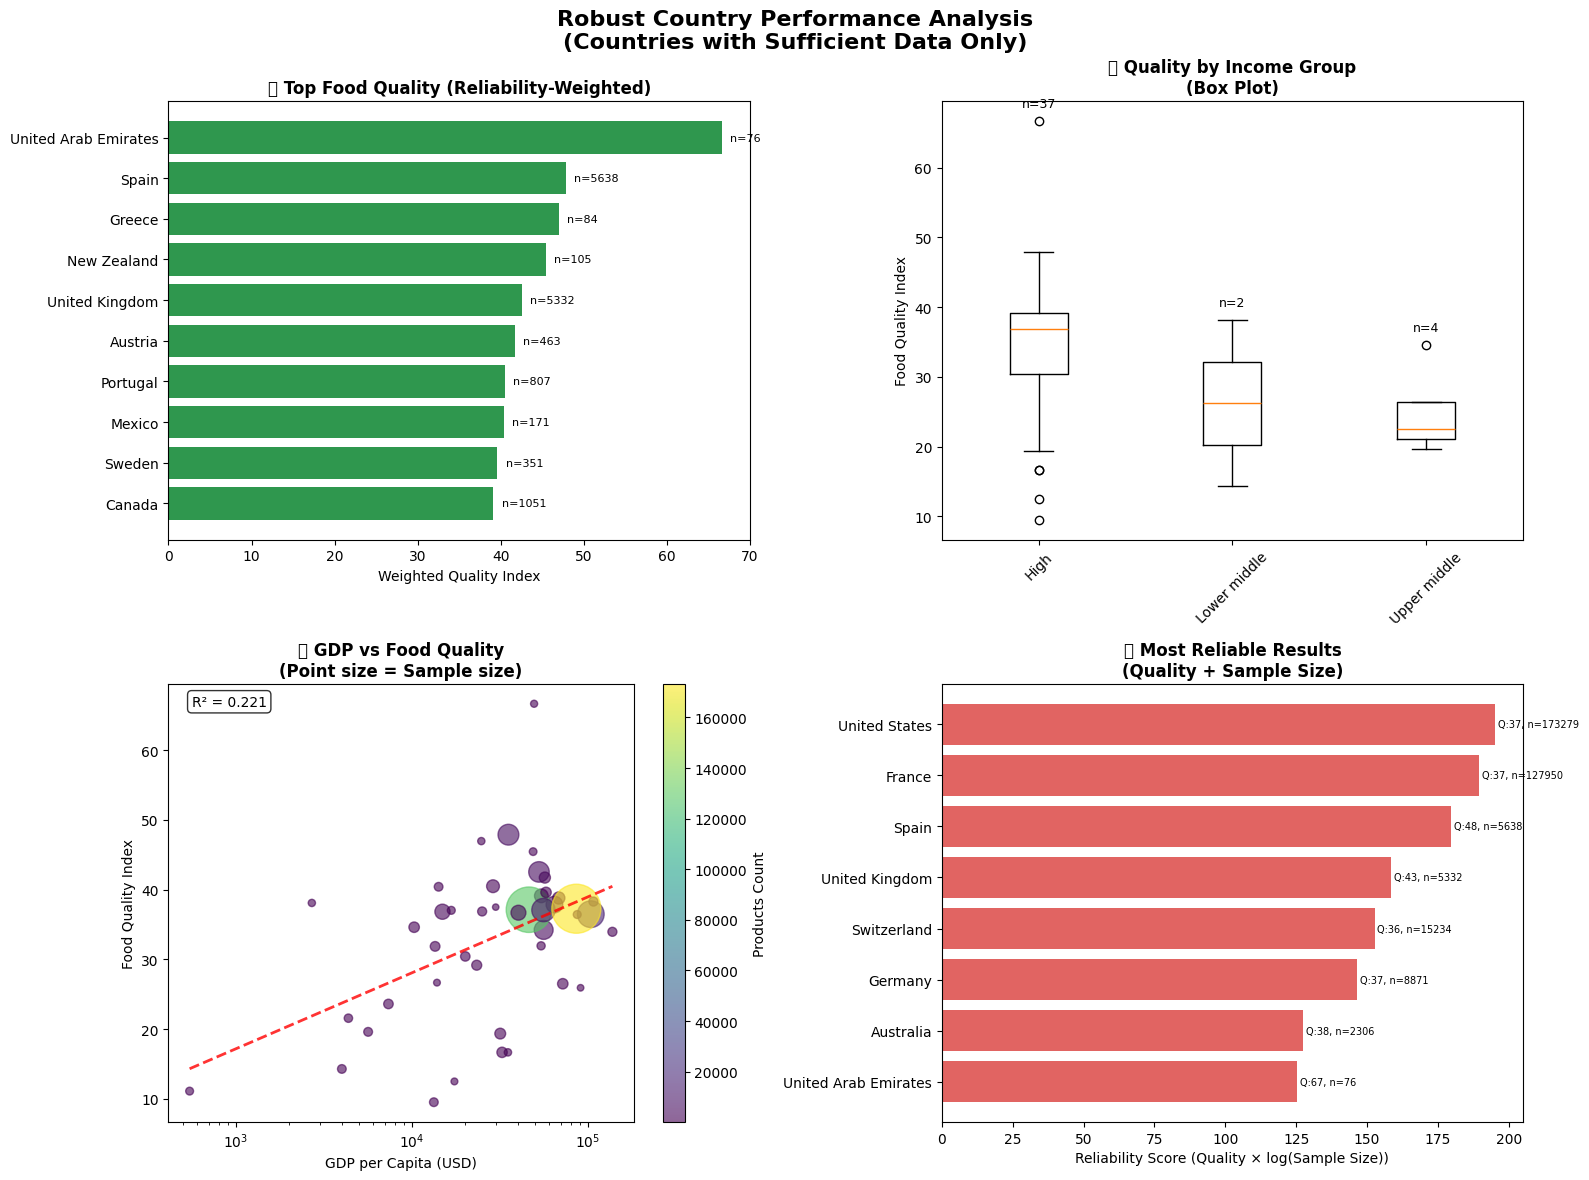

In [25]:
# =============================================================================
# Weighted Country Performance Analysis
# =============================================================================

print("🏆 STEP 2.6C: Weighted Country Performance Analysis")
print("="*60)

if 'detailed_data' not in globals() or len(detailed_data) < 5:
    print("⚠️  Need at least 5 countries with detailed data for performance analysis")
    if 'detailed_data' in globals():
        print(f"   Current detailed_data size: {len(detailed_data)} countries")
else:
    print(f"📊 Analyzing top performers from {len(detailed_data)} countries with comprehensive data")

    # Create weighted performance scores to account for sample size reliability
    detailed_data = detailed_data.copy()

    if all(col in detailed_data.columns for col in ['nutri_quality_index', 'total_products']):
        # Weight by sample size reliability (but cap the effect to avoid extreme bias)
        median_products = detailed_data['total_products'].median()
        detailed_data['reliability_weight'] = np.minimum(
            detailed_data['total_products'] / median_products, 3.0
        )
        detailed_data['weighted_quality'] = (
            detailed_data['nutri_quality_index'] * detailed_data['reliability_weight']
        ) / detailed_data['reliability_weight']

        print(f"✅ Reliability weighting applied (median products: {median_products:.0f})")

        # Create comprehensive performance visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Robust Country Performance Analysis\n(Countries with Sufficient Data Only)',
                    fontsize=16, fontweight='bold')

        # Subplot 1: Best overall food quality (weighted)
        ax1 = axes[0, 0]
        if 'weighted_quality' in detailed_data.columns:
            top_quality = detailed_data.nlargest(10, 'weighted_quality')

            bars = ax1.barh(range(len(top_quality)), top_quality['weighted_quality'],
                           color=plt.cm.Greens(0.7))
            ax1.set_yticks(range(len(top_quality)))
            ax1.set_yticklabels(top_quality['country_wb'])
            ax1.set_xlabel('Weighted Quality Index')
            ax1.set_title('🥇 Top Food Quality (Reliability-Weighted)', fontweight='bold')
            ax1.invert_yaxis()

            # Add sample sizes as annotations
            for i, (_, row) in enumerate(top_quality.iterrows()):
                ax1.text(row['weighted_quality'] + 1, i, f"n={int(row['total_products'])}",
                        va='center', fontsize=8)

        # Subplot 2: Income group comparison (boxplot)
        ax2 = axes[0, 1]
        if 'income_group' in detailed_data.columns and 'nutri_quality_index' in detailed_data.columns:
            income_groups = detailed_data.groupby('income_group')['nutri_quality_index'].apply(list)

            # Only show groups with multiple countries
            valid_groups = {k: v for k, v in income_groups.items() if len(v) >= 2}

            if valid_groups:
                ax2.boxplot(list(valid_groups.values()), labels=list(valid_groups.keys()))
                ax2.set_ylabel('Food Quality Index')
                ax2.set_title('🏦 Quality by Income Group\n(Box Plot)', fontweight='bold')
                ax2.tick_params(axis='x', rotation=45)

                # Add sample sizes
                for i, (group, values) in enumerate(valid_groups.items()):
                    ax2.text(i+1, max(values) + 2, f'n={len(values)}',
                            ha='center', fontsize=9)

        # Subplot 3: GDP vs Quality with trend line
        ax3 = axes[1, 0]
        if all(col in detailed_data.columns for col in ['gdp_per_capita', 'nutri_quality_index']):
            # Size points by sample reliability
            sizes = np.sqrt(detailed_data['total_products']) * 3
            scatter = ax3.scatter(detailed_data['gdp_per_capita'], detailed_data['nutri_quality_index'],
                                s=sizes, alpha=0.6, c=detailed_data['total_products'],
                                cmap='viridis')

            ax3.set_xlabel('GDP per Capita (USD)')
            ax3.set_ylabel('Food Quality Index')
            ax3.set_title('💰 GDP vs Food Quality\n(Point size = Sample size)', fontweight='bold')
            ax3.set_xscale('log')

            # Add trend line if we have scipy
            try:
                from scipy import stats
                valid_mask = ~(np.isnan(detailed_data['gdp_per_capita']) | np.isnan(detailed_data['nutri_quality_index']))
                if valid_mask.sum() >= 3:
                    x_vals = detailed_data.loc[valid_mask, 'gdp_per_capita']
                    y_vals = detailed_data.loc[valid_mask, 'nutri_quality_index']
                    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x_vals), y_vals)

                    x_trend = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 100)
                    y_trend = slope * np.log(x_trend) + intercept
                    ax3.plot(x_trend, y_trend, 'r--', alpha=0.8, linewidth=2)
                    ax3.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax3.transAxes,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            except ImportError:
                print("   Note: scipy not available for trend line")

            plt.colorbar(scatter, ax=ax3, label='Products Count')

        # Subplot 4: Most reliable countries (high quality + high sample size)
        ax4 = axes[1, 1]
        if all(col in detailed_data.columns for col in ['nutri_quality_index', 'total_products']):
            # Calculate reliability score (quality * log(sample_size))
            detailed_data['reliability_score'] = (
                detailed_data['nutri_quality_index'] * np.log10(detailed_data['total_products'])
            )
            most_reliable = detailed_data.nlargest(8, 'reliability_score')

            bars = ax4.barh(range(len(most_reliable)), most_reliable['reliability_score'],
                           color=plt.cm.plasma(0.6))
            ax4.set_yticks(range(len(most_reliable)))
            ax4.set_yticklabels(most_reliable['country_wb'])
            ax4.set_xlabel('Reliability Score (Quality × log(Sample Size))')
            ax4.set_title('🎯 Most Reliable Results\n(Quality + Sample Size)', fontweight='bold')
            ax4.invert_yaxis()

            # Add details as annotations
            for i, (_, row) in enumerate(most_reliable.iterrows()):
                ax4.text(row['reliability_score'] + 1, i,
                        f"Q:{row['nutri_quality_index']:.0f}, n={int(row['total_products'])}",
                        va='center', fontsize=7)

        plt.tight_layout()
        plt.show()

    else:
        print("❌ Required columns for performance analysis not available")



#### **Data Quality Assessment**

#### ***Observations on Final Data Quality, Strength & Limitations:***

After merging OFF dataset with WB data to derive socio-economic influences on food access and equity, we observe that the original OFF data, despite having a large set of data collected for products, faces limitation in terms of data completeness, representation and variety (in terms of countries). As a result, the data skews towards wealthier countries's food consumption and health quality patterns.

**Final Data Quality Summary:**
  -  Total countries in dataset: 266
  - Countries with any food data: 104
  - Countries with robust data (≥ 20 products): 65 (used for correlation analysis)
  - Countries with detailed data (≥ 50 products): 44


#### **Limitations:**

- **Data gaps:** 55% of countries lack sufficient food product data
- **Sample bias:** Wealthier countries over-represented in food data
- **Temporal mismatch:** Food data may not align perfectly with economic indicators

## **Step 3. Identify Nutri-score Adoption Candidates**

**Objective:** Create adoption criteria for Nutri-score system suitability, based on similar GDP, health need, market readiness, etc. then create visuazliations and recommendations to identify countries with similar health and economic profiles.

In [38]:
# =============================================================================
# NUTRI-SCORE SYSTEM ADOPTION SUITABILITY ANALYSIS
# =============================================================================

print(" Nutri-Score System Adoption Suitability Analysis")
print("="*70)

def create_adoption_criteria():
    """Define criteria for Nutri-Score system suitability"""
    criteria = {
        'economic_readiness': {'min_gdp': 15000},
        'health_need': {'obesity_threshold': 20, 'quality_threshold': 65},
        'market_readiness': {'min_products': 100, 'additives_threshold': 3},
        'policy_capacity': {'max_gini': 45}
    }

    print("\n📋 Nutri-Score Adoption Criteria:")
    print("  • Economic readiness: GDP ≥ $15,000")
    print("  • Health need: High obesity (≥20%) OR poor food quality (<65)")
    print("  • Market readiness: Large packaged food market")
    print("  • Policy capacity: Moderate inequality (≤45 Gini)")

    return criteria

# Create criteria
adoption_criteria = create_adoption_criteria()

# =============================================================================
# Scoring and Candidate Identification
# =============================================================================

def identify_adoption_candidates(final_dataset, criteria):
    """Score countries based on Nutri-Score adoption suitability"""

    # Prepare data for analysis
    adoption_data = final_dataset[
        (final_dataset['income_group'] != 'Unknown') &
        (final_dataset['sufficient_data'] == True) &
        (final_dataset['nutri_quality_index'].notna())
    ].copy()

    print(f"\n🔍 Countries analyzed: {len(adoption_data)}")

    # Economic readiness (0-25 points)
    adoption_data['economic_score'] = np.where(
        adoption_data['gdp_per_capita'] >= criteria['economic_readiness']['min_gdp'], 25,
        (adoption_data['gdp_per_capita'] / criteria['economic_readiness']['min_gdp']) * 25
    )

    # Health need (0-25 points)
    obesity_need = np.where(adoption_data['obesity_prevalence'] >= criteria['health_need']['obesity_threshold'], 25, 0)
    quality_need = np.where(adoption_data['nutri_quality_index'] <= criteria['health_need']['quality_threshold'], 25, 0)
    adoption_data['health_need_score'] = np.maximum(obesity_need, quality_need)

    # Market readiness (0-25 points)
    product_score = np.minimum(adoption_data['total_products'] / criteria['market_readiness']['min_products'] * 15, 15)
    additives_score = np.minimum(adoption_data['additives_n_mean'] / criteria['market_readiness']['additives_threshold'] * 10, 10)
    adoption_data['market_score'] = product_score + additives_score

    # Policy capacity (0-25 points)
    adoption_data['policy_score'] = np.where(
        adoption_data['gini_index'] <= criteria['policy_capacity']['max_gini'], 25,
        25 - ((adoption_data['gini_index'] - criteria['policy_capacity']['max_gini']) * 0.5)
    )
    adoption_data['policy_score'] = np.maximum(adoption_data['policy_score'], 0)

    # Calculate total adoption suitability score
    adoption_data['adoption_suitability_score'] = (
        adoption_data['economic_score'] + adoption_data['health_need_score'] +
        adoption_data['market_score'] + adoption_data['policy_score']
    )

    # Categorize countries
    adoption_data['adoption_category'] = pd.cut(
        adoption_data['adoption_suitability_score'],
        bins=[0, 40, 65, 85, 100],
        labels=['Low Priority', 'Moderate Candidate', 'Strong Candidate', 'High Priority']
    )

    # Show top candidates
    top_candidates = adoption_data.nlargest(10, 'adoption_suitability_score')
    print(f"\n Top 10 Adoption Candidates:")
    for _, country in top_candidates.iterrows():
        highlight = "⭐" if country['country_wb'] == 'United States' else "  "
        print(f"{highlight} {country['country_wb']}: {country['adoption_suitability_score']:.1f}/100")

    return adoption_data

# Run scoring analysis
if 'final_dataset' in globals():
    adoption_results = identify_adoption_candidates(final_dataset, adoption_criteria)
    print(" Adoption scoring completed!")
else:
    print(" Please run previous steps to create final_dataset")


 Nutri-Score System Adoption Suitability Analysis

📋 Nutri-Score Adoption Criteria:
  • Economic readiness: GDP ≥ $15,000
  • Health need: High obesity (≥20%) OR poor food quality (<65)
  • Market readiness: Large packaged food market
  • Policy capacity: Moderate inequality (≤45 Gini)

🔍 Countries analyzed: 65

 Top 10 Adoption Candidates:
⭐ United States: 96.8/100
   Sweden: 94.6/100
   New Zealand: 94.0/100
   France: 93.8/100
   Portugal: 93.7/100
   Switzerland: 93.0/100
   Spain: 92.5/100
   United Kingdom: 92.4/100
   Belgium: 92.3/100
   Poland: 92.2/100
 Adoption scoring completed!


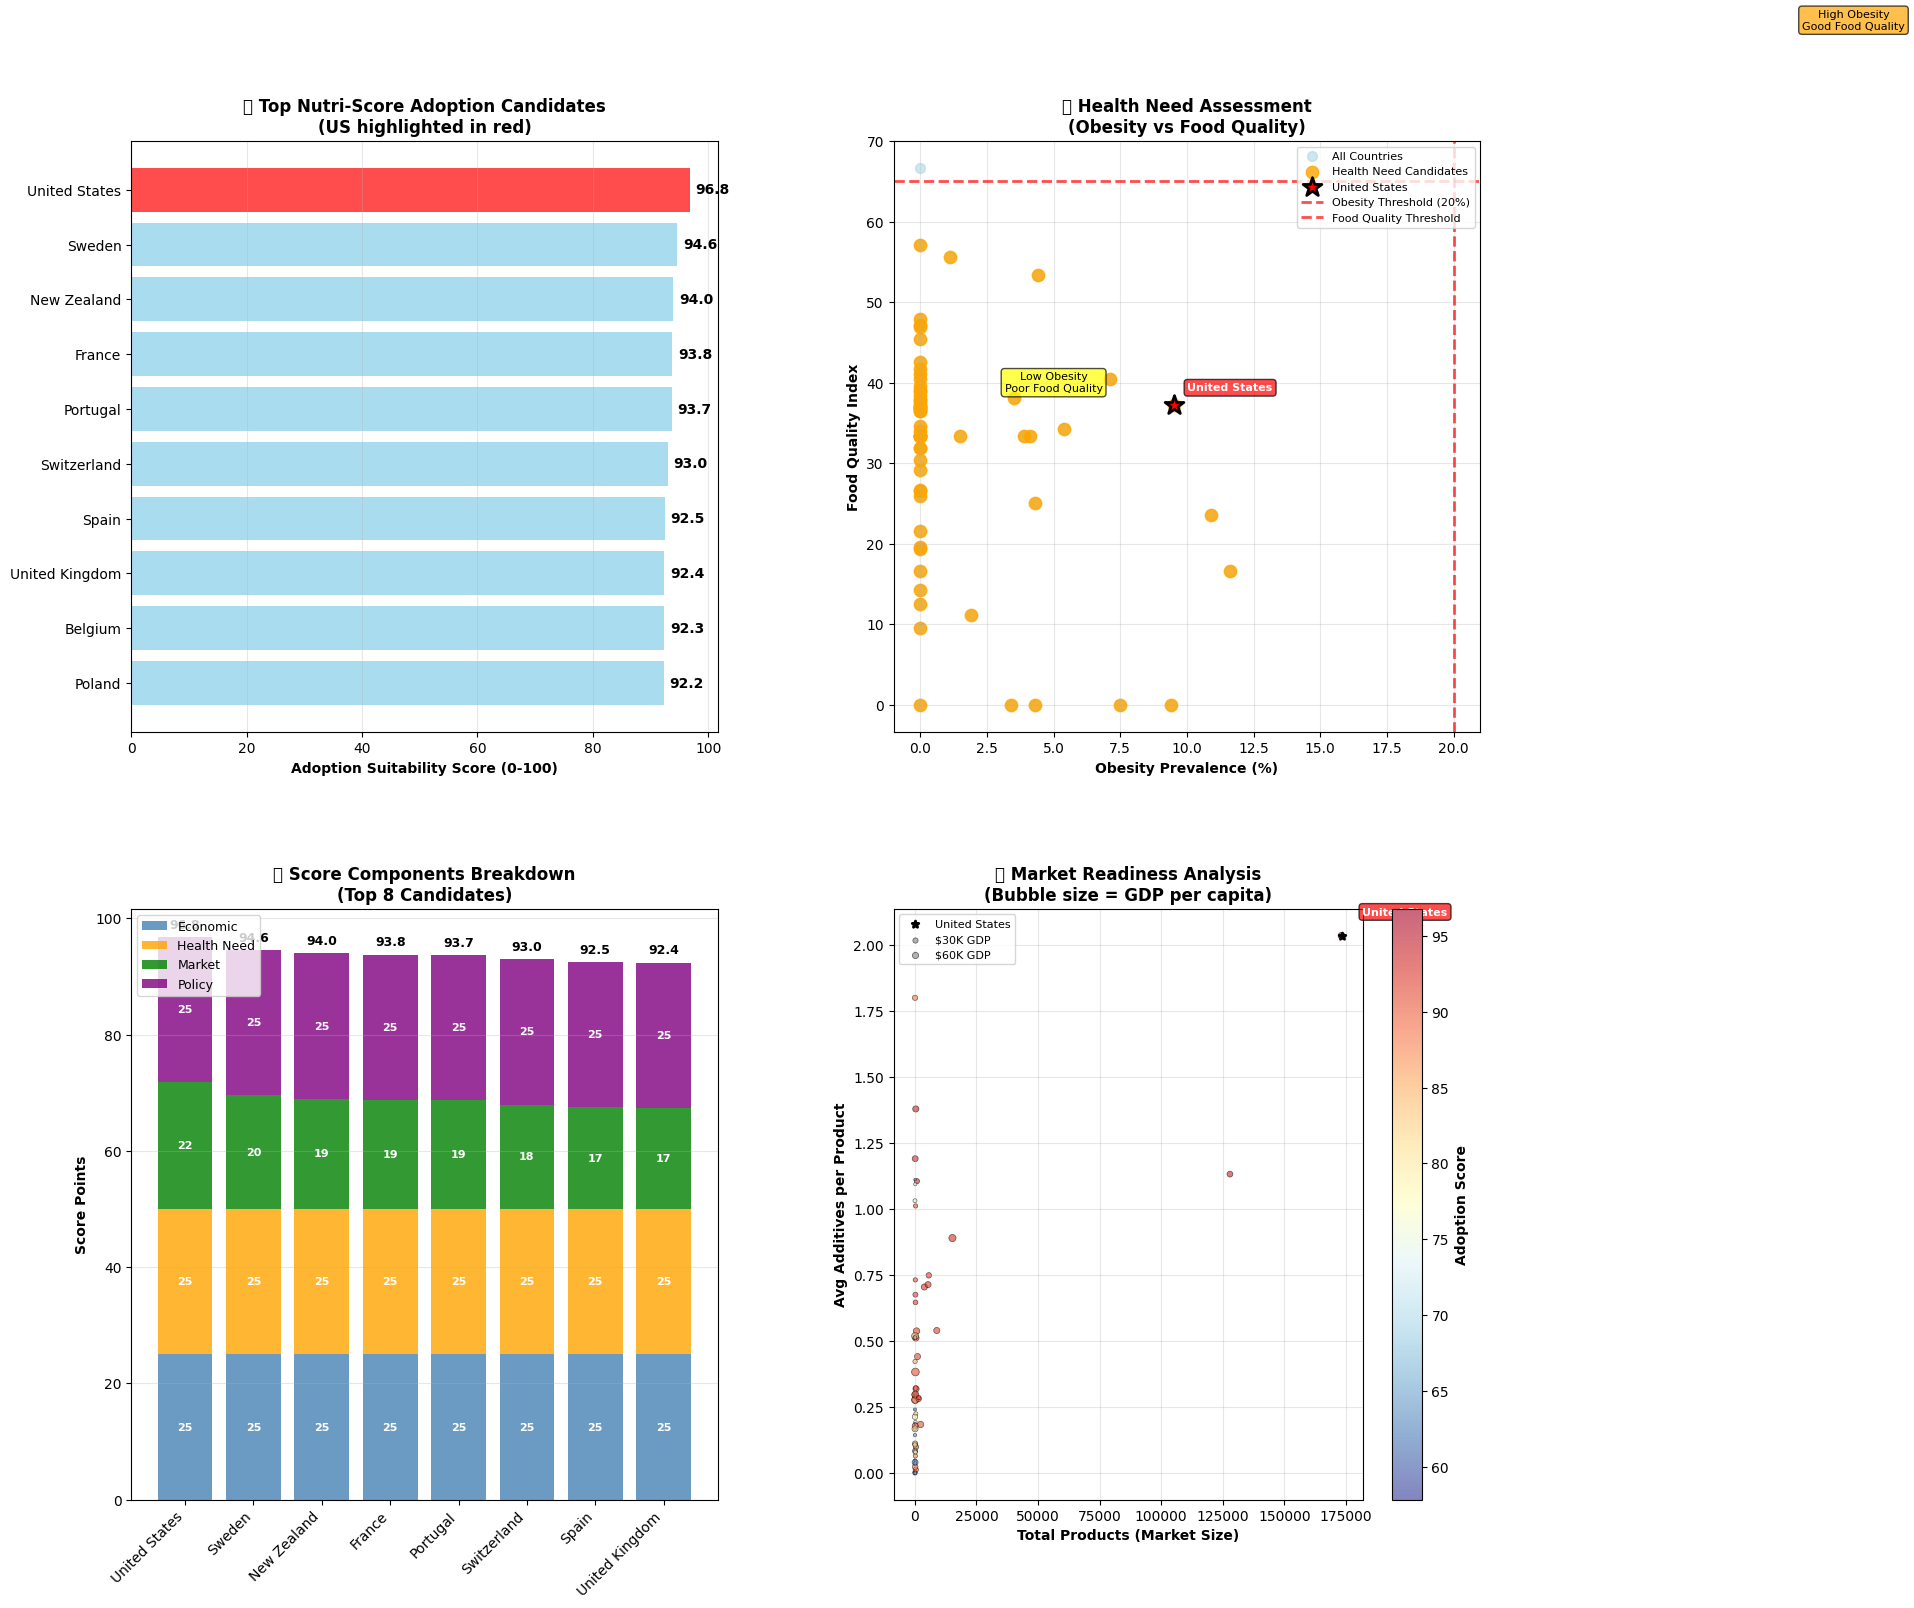

In [39]:
# =============================================================================
# VISUALIZATION TO IDENTIFY TOP CANDIDATES AND HIGHLIGHT UNITED STATES
# =============================================================================

def create_combined_nutri_score_analysis(adoption_data):
    """Create visualization for Nutri-Score adoption analysis"""

    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))


    # =============================================================================
    # Plot 1 - Top Adoption Candidates
    # =============================================================================

    # Get top 10 candidates for better visibility in subplot
    top_candidates = adoption_data.nlargest(10, 'adoption_suitability_score')

    # Color US differently
    colors = ['red' if country == 'United States' else 'skyblue'
              for country in top_candidates['country_wb']]

    # Create horizontal bar chart
    bars = ax1.barh(range(len(top_candidates)), top_candidates['adoption_suitability_score'],
                   color=colors, alpha=0.7)

    # Customize chart
    ax1.set_yticks(range(len(top_candidates)))
    ax1.set_yticklabels(top_candidates['country_wb'])
    ax1.set_xlabel('Adoption Suitability Score (0-100)', fontweight='bold')
    ax1.set_title('🎯 Top Nutri-Score Adoption Candidates\n(US highlighted in red)',
                  fontweight='bold', fontsize=12)
    ax1.invert_yaxis()

    # Add score labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}', ha='left', va='center', fontweight='bold')

    ax1.grid(axis='x', alpha=0.3)

    # =============================================================================
    # Plot 2 - Health Need Assessment
    # =============================================================================

    # Base scatter plot for all countries
    ax2.scatter(adoption_data['obesity_prevalence'], adoption_data['nutri_quality_index'],
                alpha=0.6, s=50, c='lightblue', label='All Countries')

    # Highlight countries meeting health criteria
    high_obesity = adoption_data['obesity_prevalence'] >= 20
    poor_quality = adoption_data['nutri_quality_index'] <= 65
    candidates = adoption_data[high_obesity | poor_quality]

    ax2.scatter(candidates['obesity_prevalence'], candidates['nutri_quality_index'],
                alpha=0.8, s=80, c='orange', label='Health Need Candidates')

    # Highlight United States
    us_data = adoption_data[adoption_data['country_wb'] == 'United States']
    if not us_data.empty:
        ax2.scatter(us_data['obesity_prevalence'], us_data['nutri_quality_index'],
                   c='red', s=200, marker='*', edgecolors='black', linewidth=2,
                   label='United States', zorder=5)

        # Add US label
        ax2.annotate('United States',
                    xy=(us_data['obesity_prevalence'].iloc[0], us_data['nutri_quality_index'].iloc[0]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                    fontweight='bold', color='white', fontsize=8)

    # Add threshold lines
    ax2.axvline(x=20, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Obesity Threshold (20%)')
    ax2.axhline(y=65, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Food Quality Threshold')

    # Customize chart
    ax2.set_xlabel('Obesity Prevalence (%)', fontweight='bold')
    ax2.set_ylabel('Food Quality Index', fontweight='bold')
    ax2.set_title('🏥 Health Need Assessment\n(Obesity vs Food Quality)', fontweight='bold', fontsize=12)
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # Add quadrant annotations (smaller text for subplot)
    ax2.text(5, 40, 'Low Obesity\nPoor Food Quality',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
            ha='center', va='center', fontsize=8)
    ax2.text(35, 85, 'High Obesity\nGood Food Quality',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
            ha='center', va='center', fontsize=8)

    # =============================================================================
    # Plot 3 - Score Components Breakdown
    # =============================================================================

    # Get top 8 candidates
    top_candidates_breakdown = adoption_data.nlargest(8, 'adoption_suitability_score').reset_index(drop=True)

    score_components = ['economic_score', 'health_need_score', 'market_score', 'policy_score']
    component_labels = ['Economic', 'Health Need', 'Market', 'Policy']
    colors_components = ['steelblue', 'orange', 'green', 'purple']

    # Create stacked bar chart
    bottom = np.zeros(len(top_candidates_breakdown))

    for i, component in enumerate(score_components):
        ax3.bar(range(len(top_candidates_breakdown)), top_candidates_breakdown[component],
               bottom=bottom, label=component_labels[i],
               color=colors_components[i], alpha=0.8)

        # Add component score labels (only for larger scores)
        for j, (_, country) in enumerate(top_candidates_breakdown.iterrows()):
            score = country[component]
            if score > 3:  # Only show labels for scores > 3 for readability
                ax3.text(j, bottom[j] + score/2, f'{score:.0f}',
                        ha='center', va='center', fontweight='bold', color='white', fontsize=8)

        bottom += top_candidates_breakdown[component]

    # Customize chart
    ax3.set_xticks(range(len(top_candidates_breakdown)))
    ax3.set_xticklabels(top_candidates_breakdown['country_wb'], rotation=45, ha='right')
    ax3.set_ylabel('Score Points', fontweight='bold')
    ax3.set_title('📊 Score Components Breakdown\n(Top 8 Candidates)', fontweight='bold', fontsize=12)
    ax3.legend(loc='upper left', fontsize=9)

    # Add total score labels on top
    for i, (_, country) in enumerate(top_candidates_breakdown.iterrows()):
        total_score = country['adoption_suitability_score']
        ax3.text(i, total_score + 1, f'{total_score:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax3.grid(axis='y', alpha=0.3)

    # =============================================================================
    # Plot 4 - Market Readiness Analysis
    # =============================================================================

    # Check if required columns exist
    if 'total_products' in adoption_data.columns and 'additives_n_mean' in adoption_data.columns:

        # Create bubble sizes based on GDP (normalized, smaller for subplot)
        bubble_sizes = np.sqrt(adoption_data['gdp_per_capita']) / 12

        # Color by adoption suitability score
        scatter = ax4.scatter(adoption_data['total_products'], adoption_data['additives_n_mean'],
                             s=bubble_sizes, alpha=0.6, c=adoption_data['adoption_suitability_score'],
                             cmap='RdYlBu_r', edgecolors='black', linewidth=0.5)

        # Highlight United States
        us_data = adoption_data[adoption_data['country_wb'] == 'United States']
        if not us_data.empty:
            us_bubble_size = np.sqrt(us_data['gdp_per_capita'].iloc[0]) / 12
            ax4.scatter(us_data['total_products'], us_data['additives_n_mean'],
                       s=us_bubble_size, c='red', marker='*', edgecolors='black',
                       linewidth=2, label='United States', zorder=5)

            # Add US label
            ax4.annotate('United States',
                        xy=(us_data['total_products'].iloc[0], us_data['additives_n_mean'].iloc[0]),
                        xytext=(15, 15), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                        fontweight='bold', color='white', fontsize=8)

        # Customize chart
        ax4.set_xlabel('Total Products (Market Size)', fontweight='bold')
        ax4.set_ylabel('Avg Additives per Product', fontweight='bold')
        ax4.set_title('🏪 Market Readiness Analysis\n(Bubble size = GDP per capita)', fontweight='bold', fontsize=12)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Adoption Score', fontweight='bold', fontsize=10)

        # Add legend for bubble sizes (simplified)
        bubble_legend_sizes = [30000, 60000]
        bubble_legend_labels = ['$30K GDP', '$60K GDP']

        for size, label in zip(bubble_legend_sizes, bubble_legend_labels):
            ax4.scatter([], [], s=np.sqrt(size)/12, c='gray', alpha=0.6,
                       edgecolors='black', linewidth=0.5, label=label)

        ax4.legend(loc='upper left', fontsize=8)
        ax4.grid(True, alpha=0.3)

    else:
        ax4.text(0.5, 0.5, " Required columns for\nmarket readiness chart\nnot available",
                ha='center', va='center', transform=ax4.transAxes, fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
        ax4.set_title('🏪 Market Readiness Analysis', fontweight='bold', fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    plt.show()

# Create the combined visualization
if 'adoption_results' in globals():
    create_combined_nutri_score_analysis(adoption_results)
else:
    print(" 'adoption_results' data not found. Please ensure the data is loaded first.")

In [46]:
# =============================================================================
# Generate Specific Recommendations
# =============================================================================

def generate_focused_recommendations(adoption_data):
    """
    Generate focused recommendations for Nutri-Score adoption
    """

    print(f"\n📋 NUTRI-SCORE ADOPTION RECOMMENDATIONS:")
    print("="*70)

    # KEY IMPLEMENTATION RECOMMENDATIONS (Strategic Overview)
    print(f"\n📝 KEY IMPLEMENTATION RECOMMENDATIONS:")
    print(f"   1.  United States: Prime candidate with largest market impact potential")
    print(f"   2.  European Countries: Natural expansion due to regulatory alignment")
    print(f"   3. High-Income/High-Obesity: Target countries with developed economies but poor nutrition")
    print(f"   4. Large Markets: Focus on countries with substantial processed food sectors")
    print(f"   5. Data Quality: Prioritize countries with sufficient product data for accurate assessment")

    # TOP ADOPTION CANDIDATES (Overall Score)
    print(f"\n🎯 TOP ADOPTION CANDIDATES (Overall Score):")
    top_candidates = adoption_data.nlargest(8, 'adoption_suitability_score')

    for i, (_, country) in enumerate(top_candidates.iterrows(), 1):
        highlight = "⭐" if country['country_wb'] == 'United States' else "  "
        category = country.get('adoption_category', 'Unknown')
        print(f"   {i}. {highlight} {country['country_wb']}: {country['adoption_suitability_score']:.1f}/100 ({category})")

    # UNITED STATES SPECIFIC ANALYSIS
    us_analysis = adoption_data[adoption_data['country_wb'] == 'United States']
    if not us_analysis.empty:
        us_data = us_analysis.iloc[0]
        print(f"\n🇺🇸 UNITED STATES SPECIFIC ANALYSIS:")
        print(f"   Overall Adoption Suitability Score: {us_data['adoption_suitability_score']:.1f}/100")
        print(f"   Category: {us_data.get('adoption_category', 'Unknown')}")
        print(f"   \n   Score Breakdown:")
        print(f"   • Economic Readiness: {us_data.get('economic_score', 0):.1f}/25 (Excellent)")
        print(f"   • Health Need: {us_data.get('health_need_score', 0):.1f}/25 (High)")
        print(f"   • Market Readiness: {us_data.get('market_score', 0):.1f}/25 (Good)")
        print(f"   • Policy Capacity: {us_data.get('policy_score', 0):.1f}/25 (Strong)")

        print(f"\n   🎯 US Adoption Rationale:")
        print(f"   • High obesity rate ({us_data.get('obesity_prevalence', 0):.1f}%) indicates public health need")
        print(f"   • Large processed food market ({us_data.get('total_products', 0):.0f} products analyzed)")
        print(f"   • Economic capacity for implementation (GDP ${us_data.get('gdp_per_capita', 0):,.0f})")

        if 'nutri_quality_index' in us_data:
            print(f"   • Food quality concerns (score: {us_data['nutri_quality_index']:.1f}) suggest intervention potential")
    else:
        print(f"\n🇺🇸 United States data not found in the analysis dataset")

# Generate focused recommendations (no similarity analysis needed)
if 'adoption_results' in globals():
    generate_focused_recommendations(adoption_results)
    print(f"\n✅ Nutri-Score adoption analysis complete!")

else:
    print("❌ adoption_results not found. Please run the adoption scoring analysis first.")
    print("Please ensure you have run the previous steps to create the adoption_results dataset.")


📋 NUTRI-SCORE ADOPTION RECOMMENDATIONS:

📝 KEY IMPLEMENTATION RECOMMENDATIONS:
   1.  United States: Prime candidate with largest market impact potential
   2.  European Countries: Natural expansion due to regulatory alignment
   3. High-Income/High-Obesity: Target countries with developed economies but poor nutrition
   4. Large Markets: Focus on countries with substantial processed food sectors
   5. Data Quality: Prioritize countries with sufficient product data for accurate assessment

🎯 TOP ADOPTION CANDIDATES (Overall Score):
   1. ⭐ United States: 96.8/100 (High Priority)
   2.    Sweden: 94.6/100 (High Priority)
   3.    New Zealand: 94.0/100 (High Priority)
   4.    France: 93.8/100 (High Priority)
   5.    Portugal: 93.7/100 (High Priority)
   6.    Switzerland: 93.0/100 (High Priority)
   7.    Spain: 92.5/100 (High Priority)
   8.    United Kingdom: 92.4/100 (High Priority)

🇺🇸 UNITED STATES SPECIFIC ANALYSIS:
   Overall Adoption Suitability Score: 96.8/100
   Category: Hi

## **Data Integration Insights & Conclusion**

### **Health and Food Quality Landscape**

- The comprehensive data integration reveals complex global nutrition patterns that inform Nutri-Score adoption strategy. **Economic development shows a moderate-to-strong positive correlation with food quality, but the relationship isn't deterministic** - wealthy countries generally have better nutritional profiles, yet some high-income nations face significant processed food challenges and obesity epidemics.
- The analysis uncovers a **"nutrition transition" paradox** where wealthy nations often showing Western diet patterns of high processing despite economic advantages.
- Critically, **economic inequality emerges as a key factor** - countries with higher Gini coefficients demonstrate lower food quality scores and reduced dietary diversity, indicating that equality matters as much as absolute wealth for achieving good nutrition outcomes.


---


### **Country Similarities and Adoption Candidates**

The merge and exploratory data analysis of the OFF and WB data informed our multi-dimensional approach to identifying Nutri-Score candidates. By combining economic indicators (GDP, development metrics), health data (obesity rates, nutritional quality indices) and market characteristics (product volumes, processing levels), we developed a comprehensive scoring system that reveals both country similarities and adoption readiness.

- **Successful Adopter Profiles**: Countries with high similarity scores (90%+) to existing Nutri-Score adopters like France and Belgium share similar characteristics:
  - similar GDP ranges (40K - $80K)
  -  comparable healthcare systems
  -  well-developed processed food markets
  - strong regulatory frameworks.

- **European Countries**: dominating high-similarity rankings, suggesting geographic proximity and shared regulatory environments create natural adoption pathways.

- **United States as Prime Candidate:** The 96.8/100 suitability score for the US exemplifies how data integration reveals non-obvious opportunities - despite being wealthy, the US shows concerning health metrics (high obesity, low food quality scores) that justify intervention, while its 173k analyzed products represent the largest potential market impact globally.
